In [2]:
import numpy as np
import dill
import matplotlib.pyplot as plt
import data_visualization as dv
import copy
import time
from pathlib import Path

import read_data_functions as rdf
import plot_functions as pf
from Optimal_Stopping_Object import ModelConstructor
from initializer import InitialThangs
%load_ext autoreload
%autoreload 2

# Select Exp1 or Exp2


In [3]:
experiment = "Exp1"

# Initial Thangs


In [4]:
plt.style.use("cashaback_dark")
wheel = dv.ColorWheel()

# Get path and save path 
LOAD_PATH = Path(f"D:\OneDrive - University of Delaware - o365\Subject_Data\MatchPennies_Agent_{experiment}")
SAVE_PATH = f"D:\\OneDrive - University of Delaware - o365\\Subject_Data\\MatchPennies_Agent_{experiment}\\Figures\\"
it = InitialThangs(experiment)

# Pickle Data


In [5]:
if 'group' not in locals():
    group = rdf.generate_subject_object_v3(experiment,'All Trials')

# Create Model


Set inputs for model

In [6]:
if experiment == "Exp1":
    rt = np.nanmedian(np.nanmedian(group.movement_metrics.reaction_times, axis=1)) - 25
    rt_sd = np.nanmedian(np.nanstd(group.movement_metrics.reaction_times, axis=1))

elif experiment == "Exp2":
    rt = np.nanmedian(np.nanmedian(group.movement_metrics.exp2_react_guess_reaction_time_split('react','only'), axis=1)) - 30
    rt_sd = np.nanmedian(np.nanstd(group.movement_metrics.reaction_times, axis=2))

mt                   = np.min(np.nanmedian(np.nanmedian(group.movement_metrics.movement_times('task'), axis=2), axis=0)) # Get movement time for the condition where they tried the hardest
mt_sd                = np.nanmedian(np.nanstd(group.movement_metrics.movement_times('task'), axis=1))
time_sd              = np.array([np.nanmedian(np.nanstd(group.movement_metrics.coincidence_reach_time, axis=1))] * it.num_blocks)
perc_wins_both_reach = np.nanmean(group.score_metrics.wins_when_both_reach(perc=True), axis=0)
guess_sd             = np.nanmedian(np.nanstd(group.react_guess_movement_metrics.movement_onset_times('guess'), axis=2), axis=0)
agent_sds            = np.nanmean(np.nanstd(group.raw_data.agent_task_leave_time, axis=2), axis=0)
agent_means          = np.nanmean(np.nanmean(group.raw_data.agent_task_leave_time, axis=2), axis=0)
guess_leave_time_sd    = np.nanmedian(np.nanstd(group.react_guess_movement_metrics.movement_onset_times('guess'),axis=2),axis=0)
#* Set win, incorrect, indecision reward if messing around with beta parameters
win_reward = 1.0
indecision_cost = 0.0
incorrect_cost = 0.0


Run model without switch cost

In [7]:
# Switch cost is the switch delay and the switch sd
# In this case we 
model_no_switch  = ModelConstructor(
        experiment=experiment,
        num_blocks=it.num_blocks,
        num_timesteps=1800,
        agent_means=np.array([agent_means,agent_means])[:,:,np.newaxis],
        agent_sds=np.array([agent_sds,agent_sds])[:,:,np.newaxis], #!
        reaction_time=np.array([rt, rt])[:,np.newaxis,np.newaxis],
        movement_time=np.array([mt, mt])[:,np.newaxis,np.newaxis],
        reaction_sd=np.array([rt_sd, rt_sd])[:,np.newaxis,np.newaxis], #! Reducing these, aka the particiapnt thinks they are more certain than they are
        movement_sd=np.array([mt_sd, mt_sd ])[:,np.newaxis,np.newaxis],
        timing_sd=np.array([time_sd, time_sd])[:,:,np.newaxis],
        guess_sd = np.array([guess_leave_time_sd,guess_leave_time_sd])[:,:,np.newaxis],
        guess_switch_delay=np.array([0, 0])[:,np.newaxis,np.newaxis], # Designed like this for broadcasting reasons
        guess_switch_sd=np.array([0,0])[:,np.newaxis,np.newaxis], # This includes electromechanical delay sd and timing sd bc it's straight from data
        electromechanical_delay=np.array([50, 50])[:,np.newaxis,np.newaxis],
        switch_cost_exists=True,
        expected=True,
        win_reward=win_reward,
        incorrect_cost=incorrect_cost,
        indecision_cost=indecision_cost,
    )


In [8]:
model_full_fit = ModelConstructor(
        experiment=experiment,
        num_blocks=it.num_blocks,
        num_timesteps=1800,
        agent_means=np.array([agent_means,agent_means])[:,:,np.newaxis],
        agent_sds=np.array([agent_sds,agent_sds])[:,:,np.newaxis], #!
        reaction_time=np.array([rt, rt])[:,np.newaxis,np.newaxis],
        movement_time=np.array([mt, mt])[:,np.newaxis,np.newaxis],
        reaction_sd=np.array([rt_sd, rt_sd])[:,np.newaxis,np.newaxis], #! Reducing these, aka the particiapnt thinks they are more certain than they are
        movement_sd=np.array([mt_sd, mt_sd ])[:,np.newaxis,np.newaxis],
        timing_sd=np.array([time_sd, time_sd])[:,:,np.newaxis],
        guess_sd = np.array([guess_leave_time_sd,guess_leave_time_sd])[:,:,np.newaxis],
        guess_switch_delay=np.array([65, 60])[:,np.newaxis,np.newaxis], # Designed like this for broadcasting reasons
        guess_switch_sd=np.array([30,30])[:,np.newaxis,np.newaxis], # This includes electromechanical delay sd and timing sd bc it's straight from data
        electromechanical_delay=np.array([50, 50])[:,np.newaxis,np.newaxis],
        switch_cost_exists=True,
        expected=True,
        win_reward=win_reward,
        incorrect_cost=incorrect_cost,
        indecision_cost=indecision_cost,
)

Run model with switch cost

In [9]:
start = time.time()
model_unknown_switch = ModelConstructor(
        experiment=experiment,
        num_blocks=it.num_blocks,
        num_timesteps=1800,
        agent_means=np.array([agent_means,agent_means])[:,:,np.newaxis],
        agent_sds=np.array([agent_sds,agent_sds])[:,:,np.newaxis], #!
        reaction_time=np.array([rt, rt])[:,np.newaxis,np.newaxis],
        movement_time=np.array([mt, mt])[:,np.newaxis,np.newaxis],
        reaction_sd=np.array([rt_sd, rt_sd])[:,np.newaxis,np.newaxis], #! Reducing these, aka the particiapnt thinks they are more certain than they are
        movement_sd=np.array([mt_sd, mt_sd ])[:,np.newaxis,np.newaxis],
        timing_sd=np.array([time_sd, time_sd])[:,:,np.newaxis],
        guess_sd = np.array([guess_leave_time_sd,guess_leave_time_sd])[:,:,np.newaxis],
        guess_switch_delay=np.array([65, 0])[:,np.newaxis,np.newaxis], # Designed like this for broadcasting reasons
        guess_switch_sd=np.array([30,0])[:,np.newaxis,np.newaxis], # This includes electromechanical delay sd and timing sd bc it's straight from data
        electromechanical_delay=np.array([50, 50])[:,np.newaxis,np.newaxis],
        switch_cost_exists=True,
        expected=True,
        win_reward=win_reward,
        incorrect_cost=incorrect_cost,
        indecision_cost=indecision_cost,
)

model_known_switch = ModelConstructor(
        experiment=experiment,
        num_blocks=it.num_blocks,
        num_timesteps=1800,
        agent_means=np.array([agent_means,agent_means])[:,:,np.newaxis],
        agent_sds=np.array([agent_sds,agent_sds])[:,:,np.newaxis], #!
        reaction_time=np.array([rt, rt])[:,np.newaxis,np.newaxis],
        movement_time=np.array([mt, mt])[:,np.newaxis,np.newaxis],
        reaction_sd=np.array([rt_sd, rt_sd])[:,np.newaxis,np.newaxis], #! Reducing these, aka the particiapnt thinks they are more certain than they are
        movement_sd=np.array([mt_sd, mt_sd ])[:,np.newaxis,np.newaxis],
        timing_sd=np.array([time_sd, time_sd])[:,:,np.newaxis],
        guess_sd = np.array([guess_leave_time_sd,guess_leave_time_sd])[:,:,np.newaxis],
        guess_switch_delay=np.array([65, 65])[:,np.newaxis,np.newaxis], # Designed like this for broadcasting reasons
        guess_switch_sd=np.array([30,30])[:,np.newaxis,np.newaxis], # This includes electromechanical delay sd and timing sd bc it's straight from data
        electromechanical_delay=np.array([50, 50])[:,np.newaxis,np.newaxis],
        switch_cost_exists=True,
        expected=True,
        win_reward=win_reward,
        incorrect_cost=incorrect_cost,
        indecision_cost=indecision_cost,
)

end = time.time()
print(end - start)

0.362276554107666


# Tune Model


In [10]:
# Can fit both of these straight up 
model_known_switch.fit_model(
    model_known_switch.player_behavior.wtd_leave_time,
    np.nanmedian(np.nanmedian(group.movement_metrics.movement_onset_times('task'), axis=2), axis=0),
)
model_unknown_switch.fit_model(
    model_unknown_switch.player_behavior.wtd_leave_time,
    np.nanmedian(np.nanmedian(group.movement_metrics.movement_onset_times('task'), axis=2), axis=0),
)
model_full_fit.fit_model(
    model_full_fit.player_behavior.wtd_leave_time,
    np.nanmedian(np.nanmedian(group.movement_metrics.movement_onset_times('task'), axis=2), axis=0),
)

## Shorten the function names


In [11]:
get_no_switch_metric = model_no_switch.results.get_metric
get_known_metric = model_known_switch.results.get_metric
get_unknown_metric = model_unknown_switch.results.get_metric
get_full_fit_metric = model_full_fit.results.get_metric


## Create lists

In [12]:
# get_metric_list = [get_no_switch_metric,get_known_metric,get_unknown_metric,get_full_fit_metric]
# model_list      = [model_no_switch,model_known_switch,model_unknown_switch,model_full_fit]

# Plots


In [13]:
save = False

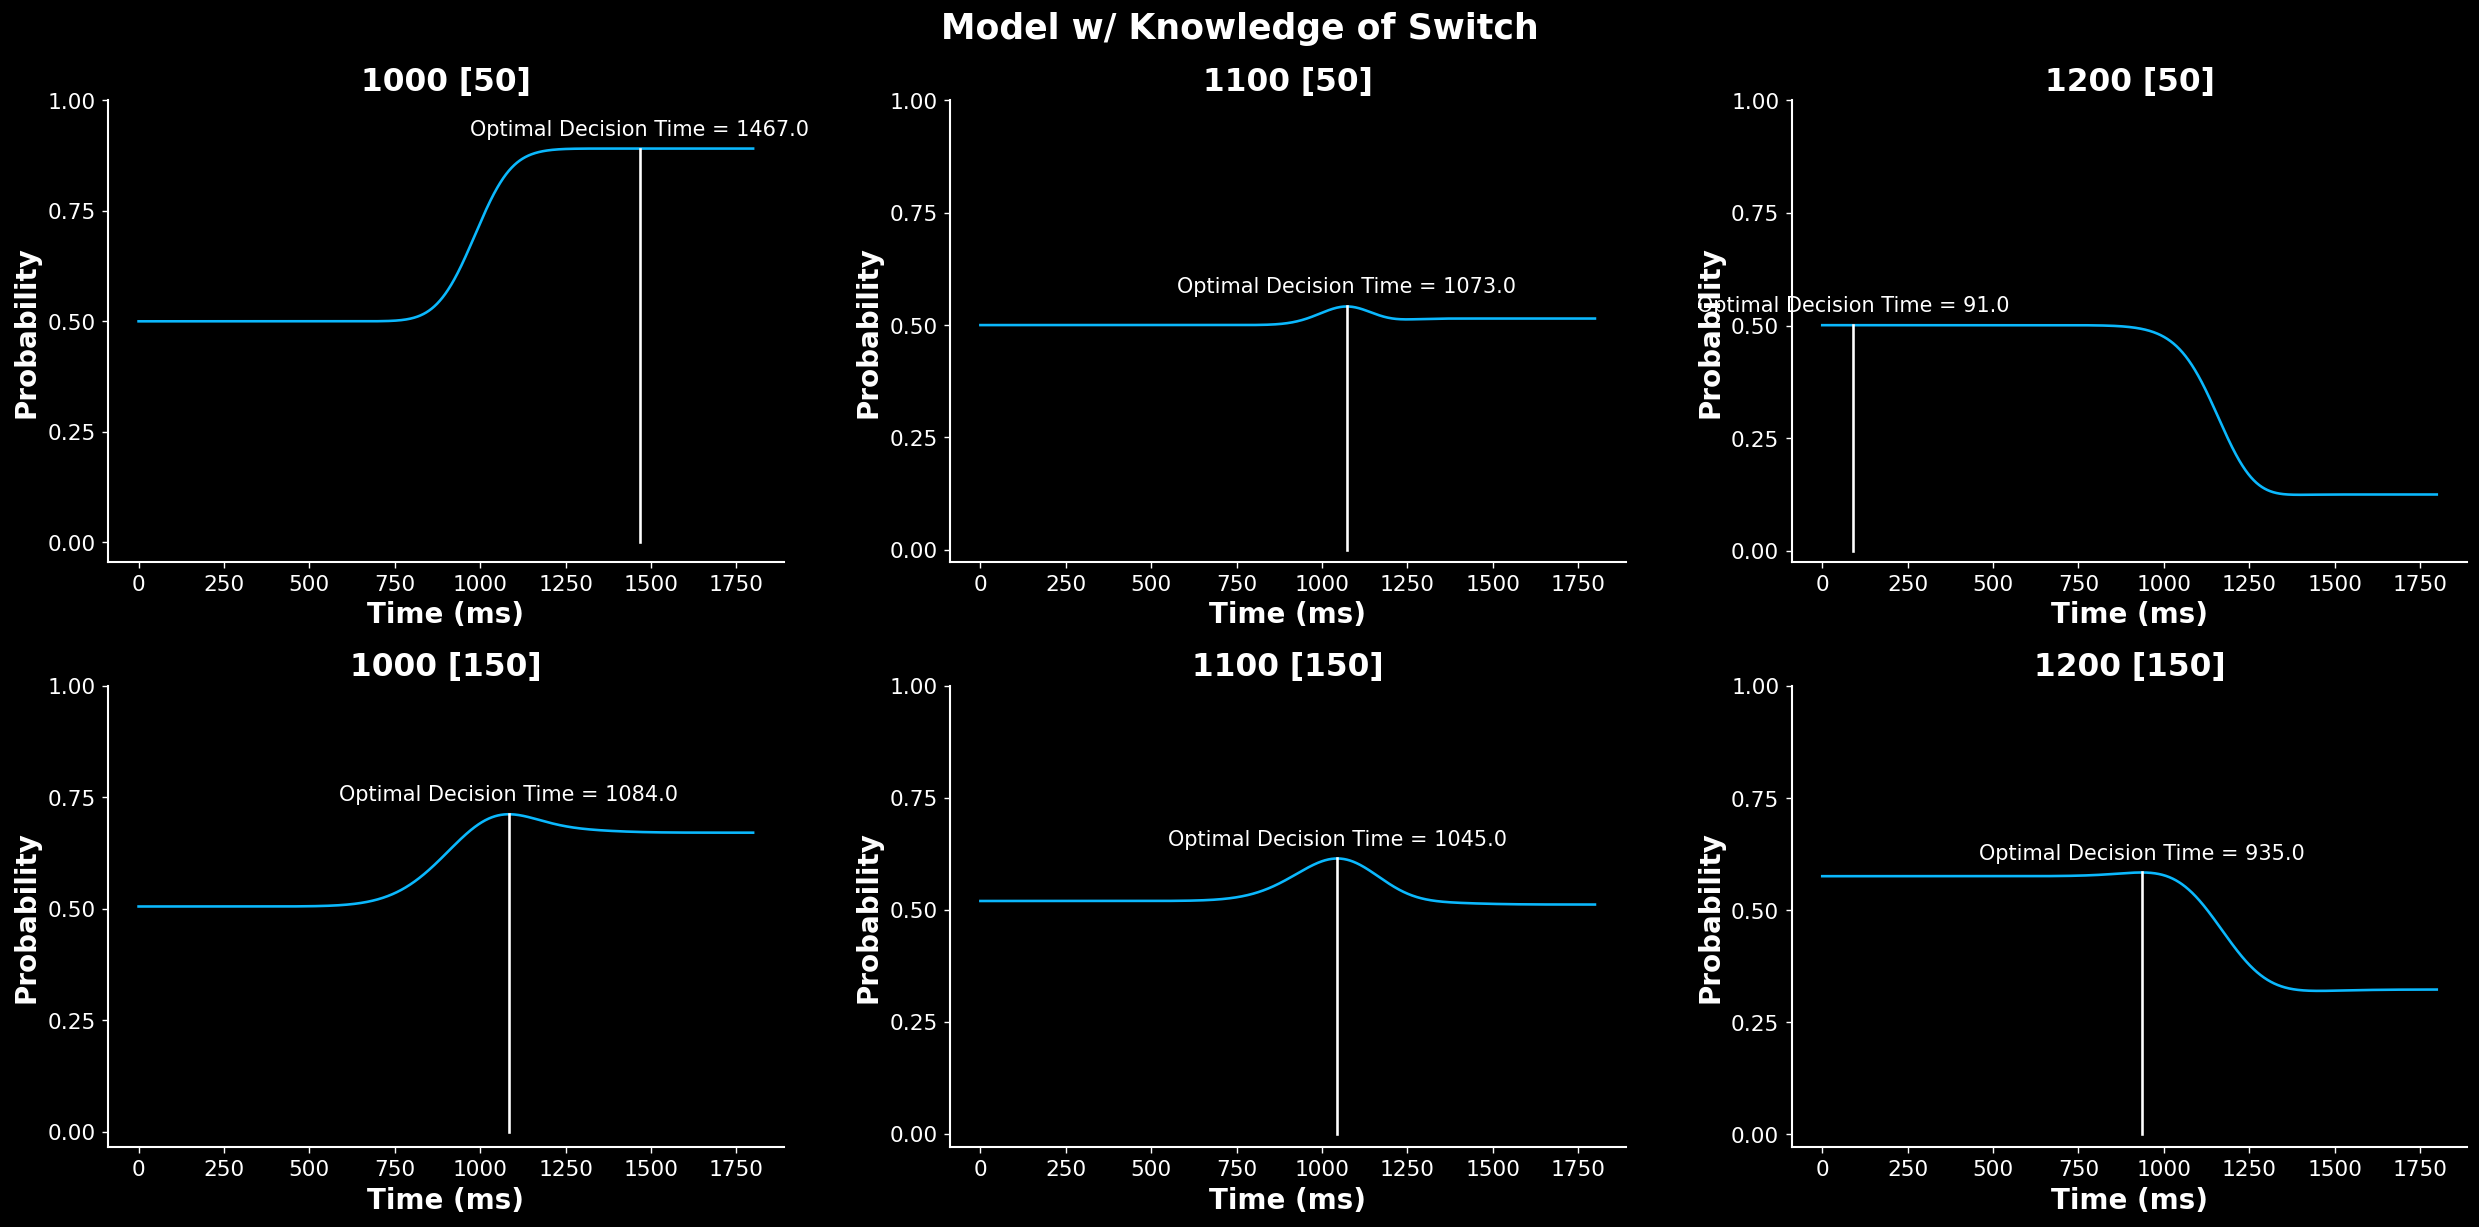

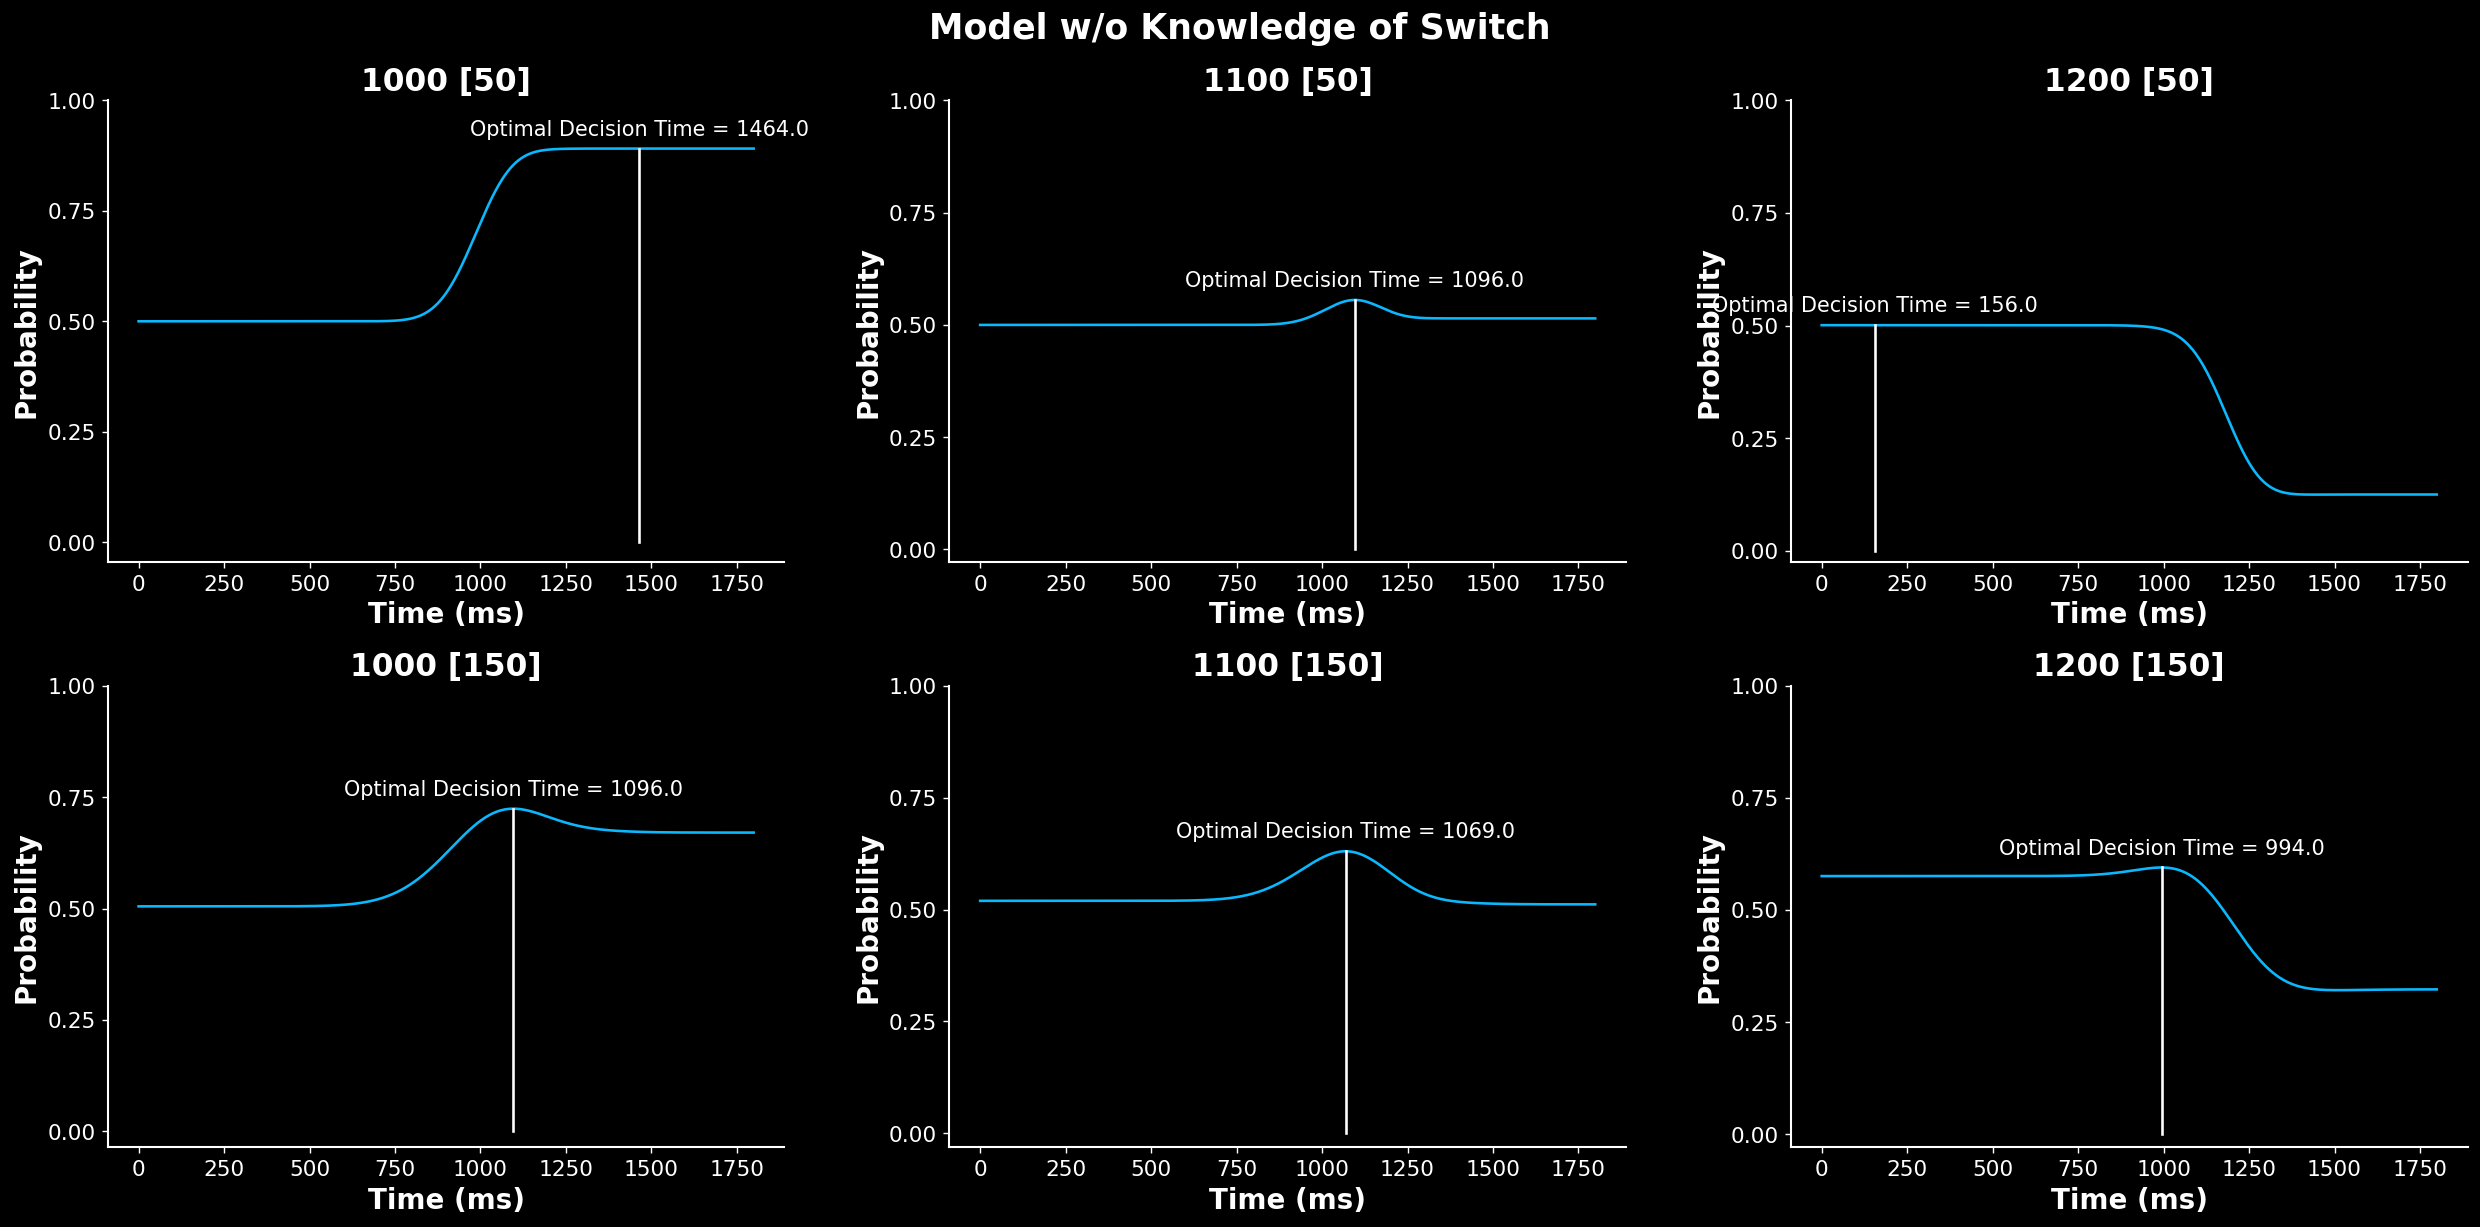

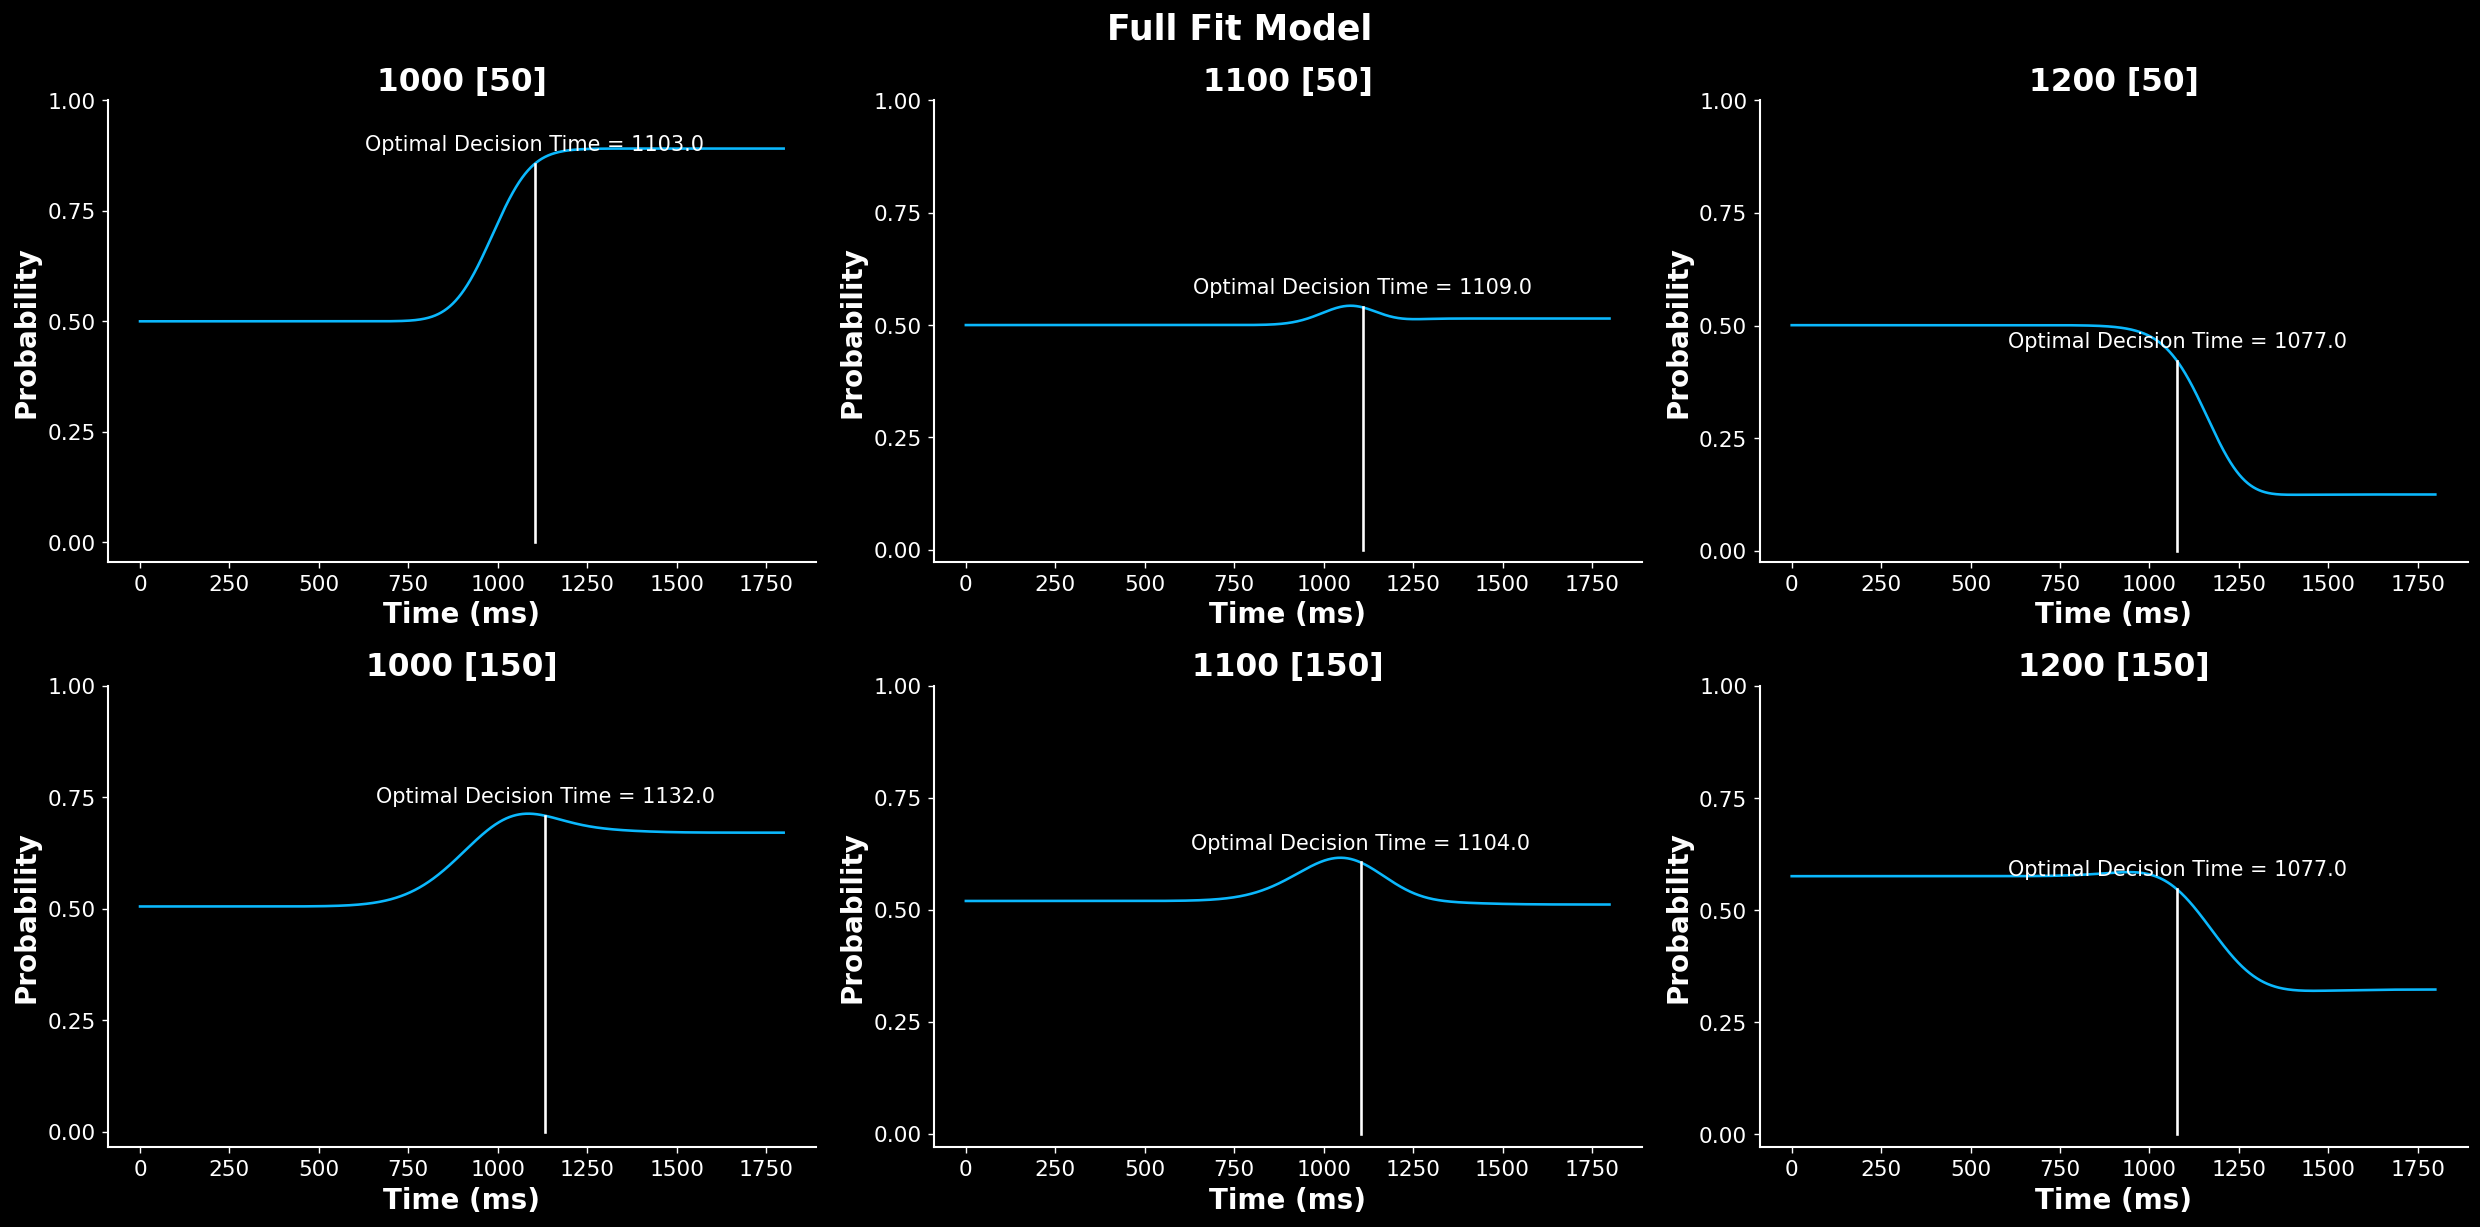

In [14]:
model_known_switch.plot_optimals(titles=it.trial_block_titles, suptitle='Model w/ Knowledge of Switch')
model_unknown_switch.plot_optimals(titles=it.trial_block_titles, suptitle='Model w/o Knowledge of Switch')
model_full_fit.plot_optimals(titles=it.trial_block_titles, optimal_fit='fit', suptitle='Full Fit Model')

Predicted Decision Time


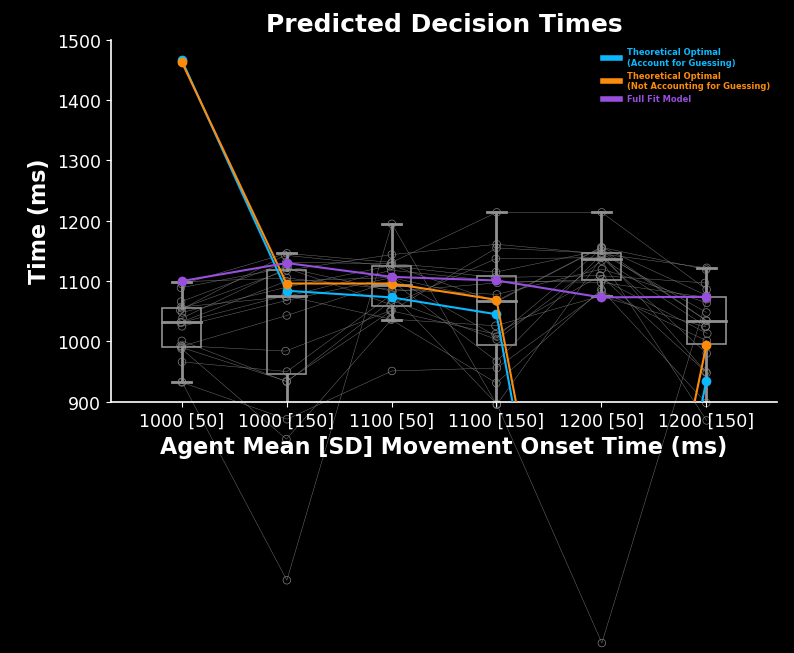

In [15]:
metric = group.decision_metrics.player_stopping_times
full_fit_metric = model_full_fit.results.fit_decision_time[0]
known_player_metric = model_known_switch.results.fit_decision_time[0]
unknown_player_metric = model_unknown_switch.results.fit_decision_time[1]
known_optimal_metric = model_known_switch.results.optimal_decision_time[0]
unknown_optimal_metric = model_unknown_switch.results.optimal_decision_time[1]
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.3, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(it.trial_block_titles))
ylocs = np.arange(900, 1600, 100)
bw = 0.75
pf.multiple_models_boxplot(
    ax,
    metric,
    show_boxplot=True,
    full_fit=full_fit_metric,
    # known_player=known_player_metric,
    # unknown_player=unknown_player_metric,
    known_optimal=known_optimal_metric,
    unknown_optimal=unknown_optimal_metric,
    xlocs=xlocs,
    box_width=bw,
    colors=wheel.grey,
    
    remove_parentheses_from_labels=False,
)

ax.set_xticks(xlocs)
ax.set_yticks(ylocs)
ax.set_xticklabels(it.trial_block_titles)
ax.set_xlim(min(xlocs) - 1.8 * bw, max(xlocs) + 1.8 * bw)
ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xlabel(it.xlabel)
ax.set_ylabel("Time (ms)")
ax.set_title("Predicted Decision Times")
if save:
    plt.savefig(SAVE_PATH + "mean_leave_target_time_with_optimal_simulation", dpi=400, transparent=True)
axmain.set_axis_off()
plt.show()

Movement Onset, Wins, Incorrects, Indecisions Panel

In [16]:
vars(model_known_switch.inputs)

{'experiment': 'Exp1',
 'num_blocks': 6,
 'agent_means': array([[[ 999.30649246],
         [1007.12019772],
         [1098.4789209 ],
         [1095.33596767],
         [1199.78896675],
         [1199.02267193]],
 
        [[ 999.30649246],
         [1007.12019772],
         [1098.4789209 ],
         [1095.33596767],
         [1199.78896675],
         [1199.02267193]]]),
 'agent_sds': array([[[ 48.76188568],
         [147.50291096],
         [ 48.62198044],
         [144.75080372],
         [ 50.77207321],
         [146.45894929]],
 
        [[ 48.76188568],
         [147.50291096],
         [ 48.62198044],
         [144.75080372],
         [ 50.77207321],
         [146.45894929]]]),
 'nsteps': 1,
 'num_timesteps': 1800,
 'timesteps': array([[[0.000e+00, 1.000e+00, 2.000e+00, ..., 1.797e+03, 1.798e+03,
          1.799e+03],
         [0.000e+00, 1.000e+00, 2.000e+00, ..., 1.797e+03, 1.798e+03,
          1.799e+03],
         [0.000e+00, 1.000e+00, 2.000e+00, ..., 1.797e+03, 1.798e+03,
  

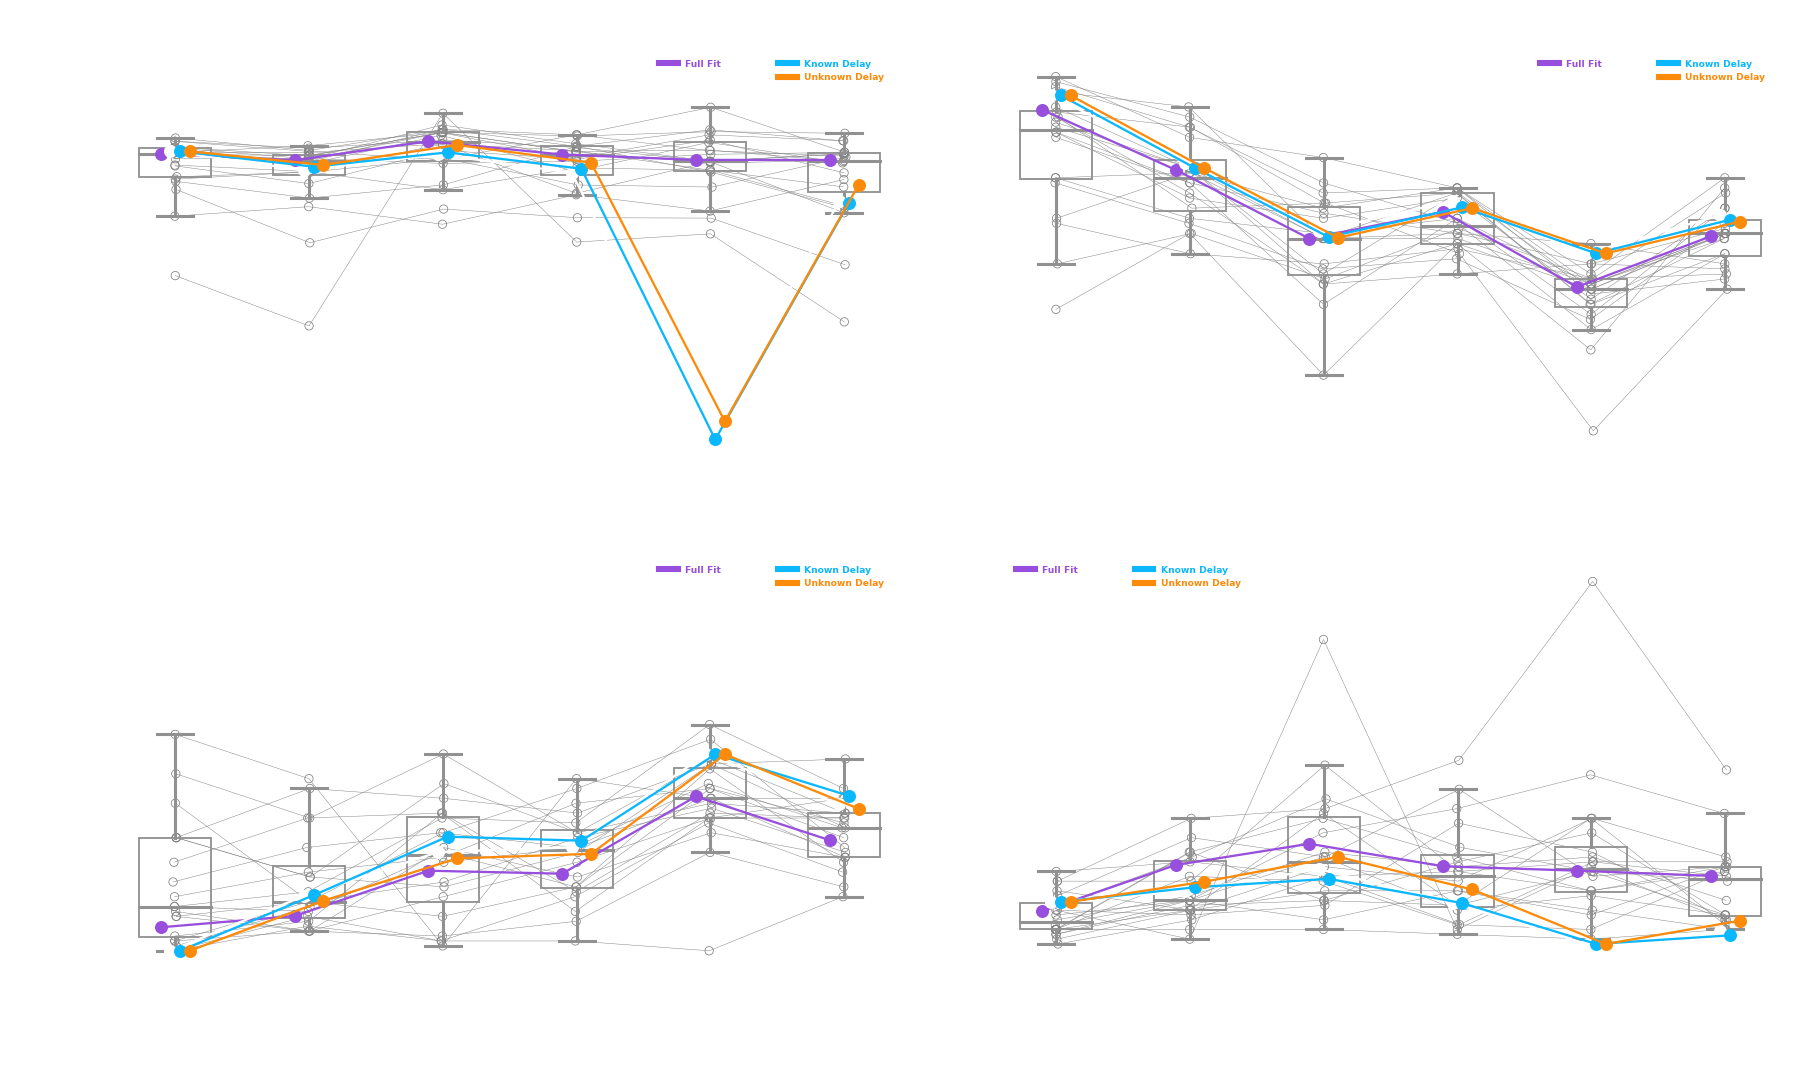

In [17]:
w,h = 16,9.2

mult_w, div_w = 0.053,2.3
div_h = 2.5
xlocs = np.linspace(0, w/div_w, num=len(it.trial_block_titles))
fig = dv.Figure(figsize=(w,h),dpi=110)
ax1 = fig.add_panel(dim=(w*mult_w,    0.3, w/div_w, h/div_h))
ax2 = fig.add_panel(dim=(w/div_w+1.9, 0.3, w/div_w, h/div_h))
ax3 = fig.add_panel(dim=(w*mult_w,    4.9, w/div_w, h/div_h))
ax4 = fig.add_panel(dim=(w/div_w+1.9, 4.9, w/div_w, h/div_h))

if True:
    metric1                 = np.nanmedian(group.movement_metrics.movement_onset_times('task'), axis=2)
    full_fit_metric1        = get_full_fit_metric(model_full_fit.player_behavior.wtd_leave_time,metric_type='true',decision_type='fit')
    no_switch_metric1       = get_no_switch_metric(model_no_switch.player_behavior.wtd_leave_time,metric_type='true',decision_type='optimal')
    known_optimal_metric1   = get_known_metric(model_known_switch.player_behavior.wtd_leave_time, metric_type='true',decision_type='optimal')
    unknown_optimal_metric1 = get_unknown_metric(model_unknown_switch.player_behavior.wtd_leave_time, metric_type='true',decision_type='optimal')
    
    ylocs1 = np.arange(400, 1601, 200)
    pf.multiple_models_boxplot_v2(
        ax=ax1,
        data=metric1,
        model_data=[full_fit_metric1, no_switch_metric1, known_optimal_metric1, unknown_optimal_metric1],
        labels=['Full Fit', 'No Switch Delay', 'Known Delay', 'Unknown Delay'],
        show_boxplot=True,
        box_width=bw,
        colors=wheel.grey,
        linestyles=["-"]*4,
        line_colors = [wheel.purple, wheel.white, wheel.rak_blue, wheel.rak_orange],
        xlocs=xlocs,
        ylocs=ylocs1,
        xticklabels=it.trial_block_titles,
        xlabel=it.xlabel,
        ylabel='Time (ms)',
        title='Movement Onset Time'
    )
    
if True:
    metric2 = group.score_metrics.score_metric('wins')/group.exp_info.num_task_trials*100
    full_fit_metric2        = get_full_fit_metric(model_full_fit.score_metrics.prob_win,metric_type='true',decision_type='fit')*100
    no_switch_metric2       = get_no_switch_metric(model_no_switch.score_metrics.prob_win,metric_type='true',decision_type='optimal')*100
    known_optimal_metric2   = get_known_metric(model_known_switch.score_metrics.prob_win, metric_type='true',decision_type='optimal')*100
    unknown_optimal_metric2 = get_unknown_metric(model_unknown_switch.score_metrics.prob_win, metric_type='true',decision_type='optimal')*100

    ylocs2 = np.arange(0, 101, 25)

    bw = 0.75
    pf.multiple_models_boxplot_v2(
        ax=ax2,
        data=metric2,
        model_data=[full_fit_metric2, no_switch_metric2, known_optimal_metric2, unknown_optimal_metric2],
        labels=['Full Fit', 'No Switch Delay', 'Known Delay', 'Unknown Delay'],
        show_boxplot=True,
        box_width=bw,
        colors=wheel.grey,
        linestyles=["-"]*4,
        xlocs=xlocs,
        ylocs=ylocs2,
        xticklabels=it.trial_block_titles,
        line_colors = [wheel.purple, wheel.white, wheel.rak_blue, wheel.rak_orange],
        xlabel=it.xlabel,
        ylabel='Wins (%)',
        title='Wins',
    )
    
if True:
    metric3 = group.score_metrics.score_metric('incorrects')/group.exp_info.num_task_trials*100
    full_fit_metric3        = get_full_fit_metric(model_full_fit.score_metrics.prob_incorrect,metric_type='true',decision_type='fit')*100
    no_switch_metric3       = get_no_switch_metric(model_no_switch.score_metrics.prob_incorrect,metric_type='true',decision_type='optimal')*100
    known_optimal_metric3   = get_known_metric(model_known_switch.score_metrics.prob_incorrect, metric_type='true',decision_type='optimal')*100
    unknown_optimal_metric3 = get_unknown_metric(model_unknown_switch.score_metrics.prob_incorrect, metric_type='true',decision_type='optimal')*100

    ylocs3 = np.arange(0, 101, 25)

    bw = 0.75
    pf.multiple_models_boxplot_v2(
        ax=ax3,
        data=metric3,
        model_data=[full_fit_metric3, no_switch_metric3, known_optimal_metric3, unknown_optimal_metric3],
        labels=['Full Fit', 'No Switch Delay', 'Known Delay', 'Unknown Delay'],
        show_boxplot=True,
        box_width=bw,
        colors=wheel.grey,
        line_colors = [wheel.purple, wheel.white, wheel.rak_blue, wheel.rak_orange],
        linestyles=["-"]*4,
        xlocs=xlocs,
        ylocs=ylocs3,
        xticklabels=it.trial_block_titles,
        xlabel=it.xlabel,
        ylabel='Incorrects (%)',
        title='Incorrects',
    )
    
    
if True:
    metric4 = group.score_metrics.score_metric('indecisions')/group.exp_info.num_task_trials*100
    full_fit_metric4        = get_full_fit_metric(model_full_fit.score_metrics.prob_indecision,metric_type='true',decision_type='fit')*100
    no_switch_metric4       = get_no_switch_metric(model_no_switch.score_metrics.prob_indecision,metric_type='true',decision_type='optimal')*100
    known_optimal_metric4   = get_known_metric(model_known_switch.score_metrics.prob_indecision, metric_type='true',decision_type='optimal')*100
    unknown_optimal_metric4 = get_unknown_metric(model_unknown_switch.score_metrics.prob_indecision, metric_type='true',decision_type='optimal')*100

    ylocs4 = np.arange(0, 101, 25)

    bw = 0.75
    pf.multiple_models_boxplot_v2(
        ax=ax4,
        data=metric4,
        model_data=[full_fit_metric4, no_switch_metric4, known_optimal_metric4, unknown_optimal_metric4],
        labels=['Full Fit', 'No Switch Delay', 'Known Delay', 'Unknown Delay'],
        show_boxplot=True,
        box_width=bw,
        colors=wheel.grey,
        line_colors = [wheel.purple, wheel.white, wheel.rak_blue, wheel.rak_orange],
        linestyles=["-"]*4,
        xlocs=xlocs,
        ylocs=ylocs4,
        xticklabels=it.trial_block_titles,
        xlabel=it.xlabel,
        ylabel='Indecisions (%)',
        title='Indecisions',
    )

Movement Onset Median, SD, IQR

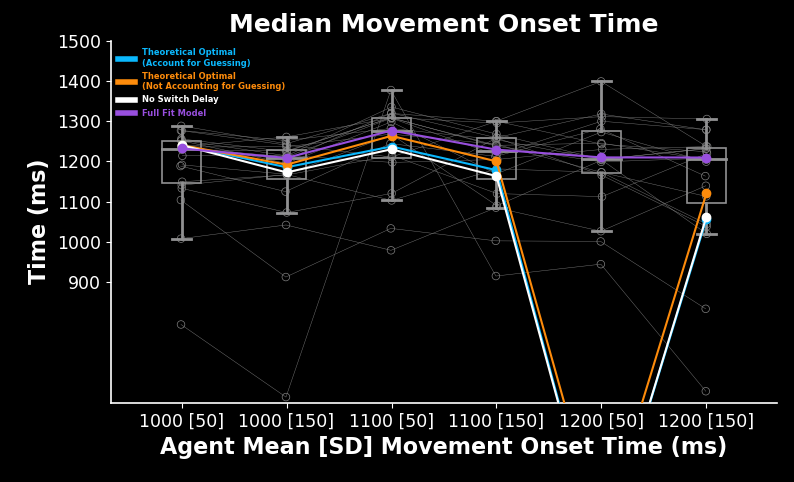

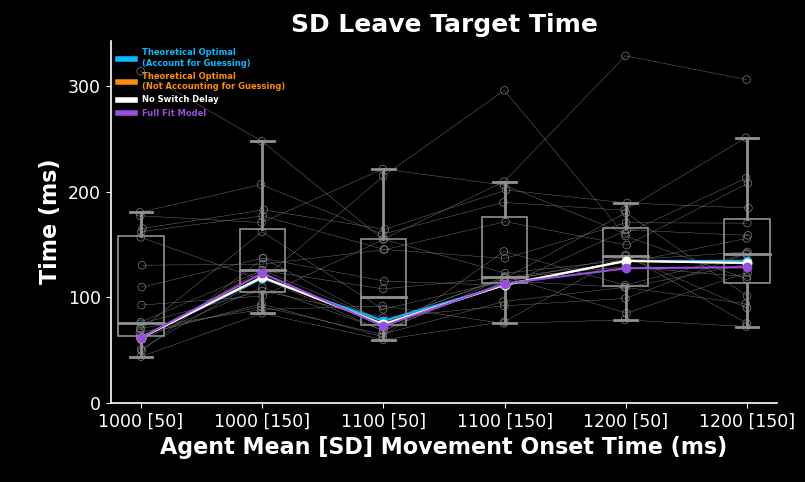

In [18]:
metric = np.nanmedian(group.movement_metrics.movement_onset_times('task'), axis=2)

no_switch_metric = get_no_switch_metric(model_no_switch.player_behavior.wtd_leave_time,metric_type='true',decision_type='optimal')
full_fit_metric = get_full_fit_metric(model_full_fit.player_behavior.wtd_leave_time,metric_type='true',decision_type='fit')
known_optimal_metric = get_known_metric(model_known_switch.player_behavior.wtd_leave_time, metric_type='true',decision_type='optimal')
known_player_metric = get_known_metric(model_known_switch.player_behavior.wtd_leave_time, metric_type='true',decision_type='fit')
unknown_optimal_metric = get_unknown_metric(model_unknown_switch.player_behavior.wtd_leave_time, metric_type='true',decision_type='optimal')
unknown_player_metric = get_unknown_metric(model_unknown_switch.player_behavior.wtd_leave_time, metric_type='true',decision_type='fit')
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.3, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(it.trial_block_titles))
ylocs = np.arange(900, 1600, 100)
bw = 0.75
pf.multiple_models_boxplot(
    ax,
    metric,
    show_boxplot=True,
    full_fit = full_fit_metric,
    no_switch = no_switch_metric,
    #known_player=known_player_metric,
    #unknown_player=unknown_player_metric,
    known_optimal=known_optimal_metric,
    unknown_optimal=unknown_optimal_metric,
    xlocs=xlocs,
    box_width=bw,
    colors=wheel.grey,
)
ax.set_xticks(xlocs), ax.set_yticks(ylocs)
ax.set_xticklabels(it.trial_block_titles)
ax.set_xlim(min(xlocs) - 1.8 * bw, max(xlocs) + 1.8 * bw)
ax.set_ylim(600, max(ylocs))

ax.set_xlabel(it.xlabel)
ax.set_ylabel("Time (ms)")
ax.set_title("Median Movement Onset Time")
if save:
    plt.savefig(SAVE_PATH + "mean_leave_target_time_with_optimal_simulation", dpi=400, transparent=True)
axmain.set_axis_off()
plt.show()

if True:
    metric = np.nanstd(group.movement_metrics.movement_onset_times('task'), axis=2)
    
    full_fit_metric = get_full_fit_metric(model_full_fit.player_behavior.wtd_leave_time_sd,metric_type='true',decision_type='fit')
    no_switch_metric = get_no_switch_metric(model_no_switch.player_behavior.wtd_leave_time_sd, metric_type='true',decision_type='optimal')
    known_optimal_metric = get_known_metric(model_known_switch.player_behavior.wtd_leave_time_sd, metric_type='true',decision_type='optimal')
    known_player_metric = get_known_metric(model_known_switch.player_behavior.wtd_leave_time_sd, metric_type='true',decision_type='fit')
    unknown_optimal_metric = get_unknown_metric(model_unknown_switch.player_behavior.wtd_leave_time_sd, metric_type='true',decision_type='optimal')
    unknown_player_metric = get_unknown_metric(model_unknown_switch.player_behavior.wtd_leave_time_sd, metric_type='true',decision_type='fit')
    w, h = 10, 6
    axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.3, 0.9, w - 1.4, h - 1.3))
    xlocs = np.linspace(0, w, num=len(it.trial_block_titles))
    ylocs = np.arange(0, 400, 100)
    bw = 0.75
    pf.multiple_models_boxplot(
        ax,
        metric,
        show_boxplot=True,
        full_fit=full_fit_metric,
        no_switch = no_switch_metric,
        #known_player=known_player_metric,
        #unknown_player=unknown_player_metric,
        known_optimal=known_optimal_metric,
        unknown_optimal=unknown_optimal_metric,
        xlocs=xlocs,
        box_width=bw,
        colors=wheel.grey,
    )

    ax.set_xticks(xlocs), ax.set_yticks(ylocs)
    ax.set_xticklabels(it.trial_block_titles)
    ax.set_xlabel(it.xlabel)
    ax.set_ylabel("Time (ms)")
    ax.set_title("SD Leave Target Time")
    # ax.plot(xlocs,get_unknown_metric(np.sqrt(model_unknown_switch.player_behavior.guess_reach_time_sd**2)))
    if save:
        plt.savefig(SAVE_PATH + "mean_leave_target_time_with_optimal_simulation", dpi=400, transparent=True)
    axmain.set_axis_off()
    plt.show()

In [ ]:
metric = np.nanmean(group.movement_metrics.movement_onset_times('task'), axis=2)

no_switch_metric = get_no_switch_metric(model_no_switch.player_behavior.wtd_leave_time,metric_type='true',decision_type='optimal')
full_fit_metric = get_full_fit_metric(model_full_fit.player_behavior.wtd_leave_time,metric_type='true',decision_type='fit')
known_optimal_metric = get_known_metric(model_known_switch.player_behavior.wtd_leave_time, metric_type='true',decision_type='optimal')
known_player_metric = get_known_metric(model_known_switch.player_behavior.wtd_leave_time, metric_type='true',decision_type='fit')
unknown_optimal_metric = get_unknown_metric(model_unknown_switch.player_behavior.wtd_leave_time, metric_type='true',decision_type='optimal')
unknown_player_metric = get_unknown_metric(model_unknown_switch.player_behavior.wtd_leave_time, metric_type='true',decision_type='fit')
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.3, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(it.trial_block_titles))
ylocs = np.arange(900, 1600, 100)
bw = 0.75
pf.multiple_models_boxplot(
    ax,
    metric,
    show_boxplot=True,
    full_fit = full_fit_metric,
    no_switch = no_switch_metric,
    #known_player=known_player_metric,
    #unknown_player=unknown_player_metric,
    known_optimal=known_optimal_metric,
    unknown_optimal=unknown_optimal_metric,
    xlocs=xlocs,
    box_width=bw,
    colors=wheel.grey,
)
ax.set_xticks(xlocs), ax.set_yticks(ylocs)
ax.set_xticklabels(it.trial_block_titles)
ax.set_xlim(min(xlocs) - 1.8 * bw, max(xlocs) + 1.8 * bw)
ax.set_ylim(600, max(ylocs))

ax.set_xlabel(it.xlabel)
ax.set_ylabel("Time (ms)")
ax.set_title("Median Movement Onset Time")
if save:
    plt.savefig(SAVE_PATH + "mean_leave_target_time_with_optimal_simulation", dpi=400, transparent=True)
axmain.set_axis_off()
plt.show()

if True:
    metric = np.nanstd(group.movement_metrics.movement_onset_times('task'), axis=2)
    
    full_fit_metric = get_full_fit_metric(model_full_fit.player_behavior.wtd_leave_time_sd,metric_type='true',decision_type='fit')
    no_switch_metric = get_no_switch_metric(model_no_switch.player_behavior.wtd_leave_time_sd, metric_type='true',decision_type='optimal')
    known_optimal_metric = get_known_metric(model_known_switch.player_behavior.wtd_leave_time_sd, metric_type='true',decision_type='optimal')
    known_player_metric = get_known_metric(model_known_switch.player_behavior.wtd_leave_time_sd, metric_type='true',decision_type='fit')
    unknown_optimal_metric = get_unknown_metric(model_unknown_switch.player_behavior.wtd_leave_time_sd, metric_type='true',decision_type='optimal')
    unknown_player_metric = get_unknown_metric(model_unknown_switch.player_behavior.wtd_leave_time_sd, metric_type='true',decision_type='fit')
    w, h = 10, 6
    axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.3, 0.9, w - 1.4, h - 1.3))
    xlocs = np.linspace(0, w, num=len(it.trial_block_titles))
    ylocs = np.arange(0, 400, 100)
    bw = 0.75
    pf.multiple_models_boxplot(
        ax,
        metric,
        show_boxplot=True,
        full_fit=full_fit_metric,
        no_switch = no_switch_metric,
        #known_player=known_player_metric,
        #unknown_player=unknown_player_metric,
        known_optimal=known_optimal_metric,
        unknown_optimal=unknown_optimal_metric,
        xlocs=xlocs,
        box_width=bw,
        colors=wheel.grey,
    )

    ax.set_xticks(xlocs), ax.set_yticks(ylocs)
    ax.set_xticklabels(it.trial_block_titles)
    ax.set_xlabel(it.xlabel)
    ax.set_ylabel("Time (ms)")
    ax.set_title("SD Leave Target Time")
    # ax.plot(xlocs,get_unknown_metric(np.sqrt(model_unknown_switch.player_behavior.guess_reach_time_sd**2)))
    if save:
        plt.savefig(SAVE_PATH + "mean_leave_target_time_with_optimal_simulation", dpi=400, transparent=True)
    axmain.set_axis_off()
    plt.show()

In [19]:
#
#! THE STANDARD DEVIATION IS NOT GOING TO FIT, BC THE OPTIMAL LEADS TO NO REACTIONS for 1200 [50], WHICH MEANS THE STD GUESS DELAY IS GOING TO BE TOUGH TO FIT

Wins


SyntaxError: keyword argument repeated: box_width (215498517.py, line 28)

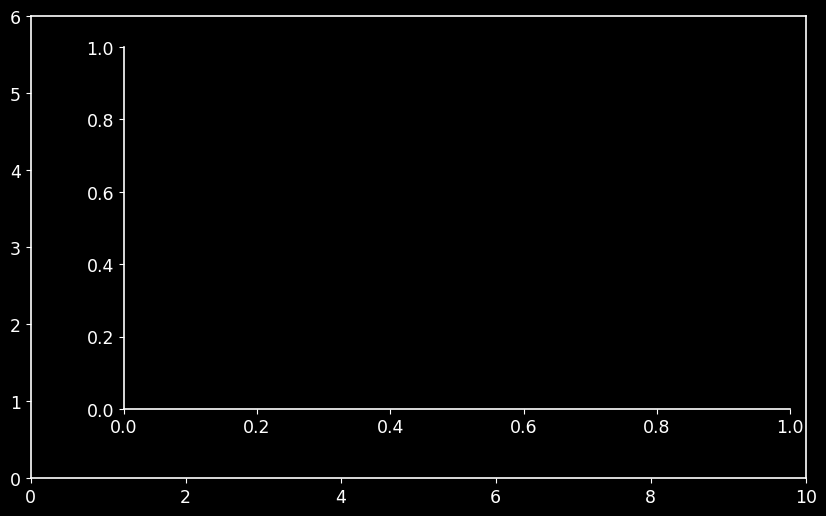

In [20]:
metric = group.score_metrics.score_metric('wins')/group.exp_info.num_task_trials*100
no_switch_metric       = get_no_switch_metric(model_no_switch.score_metrics.prob_win, decision_type='optimal', metric_type='true')*100
full_fit_metric        = get_full_fit_metric(model_full_fit.score_metrics.prob_win, decision_type='fit',metric_type='true') * 100
known_player_metric    = get_known_metric(model_known_switch.score_metrics.prob_win, decision_type='fit',metric_type='true') * 100
unknown_player_metric  = get_unknown_metric(model_unknown_switch.score_metrics.prob_win, decision_type='fit',metric_type='true') * 100
known_optimal_metric   = get_known_metric(model_known_switch.score_metrics.prob_win, decision_type='optimal',metric_type='true') * 100
unknown_optimal_metric = get_unknown_metric(model_unknown_switch.score_metrics.prob_win, decision_type='optimal',metric_type='true') * 100
w, h = 10, 6
bw = 0.4*w/it.num_blocks # box widths of all boxes combined takes up 30% of the width

axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))

xlocs = np.linspace(0, w, num=len(it.trial_block_titles))
ylocs = np.arange(0, 125, 25)

bw = 0.75
pf.multiple_models_boxplot(
    ax,
    metric,
    full_fit =full_fit_metric,
    box_width = bw,
    no_switch=no_switch_metric,
    #known_player=known_player_metric,
    #unknown_player=unknown_player_metric,
    known_optimal=known_optimal_metric,
    unknown_optimal=unknown_optimal_metric,
    xlocs=xlocs,
    box_width=bw,
    colors=wheel.grey,
    remove_parentheses_from_labels=False,
)

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))
ax.set_xticks(xlocs), ax.set_yticks(ylocs)
ax.set_xticklabels(it.trial_block_titles)
ax.set_ylim(0, 100)
ax.set_xlabel(it.xlabel)
ax.set_ylabel("Wins (%)")
# dv.custom_legend(ax,['Theoretical Optimal of Group','Model Prediction of Group'],['Orange','Green'])

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "wins_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

Points


In [ ]:
if experiment == "Exp2":
    metric = group.player_points_scored
    known_player_metric = get_known_metric(model_known_switch.expected_reward.exp_reward, metric_type='true') * group.num_task_trials[0]
    unknown_player_metric = get_unknown_metric(model_unknown_switch.expected_reward.exp_reward, metric_type='true') * group.num_task_trials[0]
    known_optimal_metric = get_known_metric(model_known_switch.expected_reward.exp_reward, metric_type='true') * group.num_task_trials[0]
    unknown_optimal_metric = get_unknown_metric(model_unknown_switch.expected_reward.exp_reward, metric_type='true') * group.num_task_trials[0]
    w, h = 10, 6
    axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
    xlocs = np.linspace(0, w, num=len(it.trial_block_titles))
    ylocs = np.arange(0, 125, 20)

    bw = 0.75
    pf.multiple_models_boxplot(
        ax,
        metric,
        #known_player=known_player_metric,
        #unknown_player=unknown_player_metric,
        known_optimal=known_optimal_metric,
        unknown_optimal=unknown_optimal_metric,
        xlocs=xlocs,
        box_width=bw,
        colors=wheel.grey,
        remove_parentheses_from_labels=False,
    )

    ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))
    ax.set_xticks(xlocs), ax.set_yticks(ylocs)
    ax.set_xticklabels(it.trial_block_titles)
    ax.set_ylim(-20, 80)
    ax.set_xlabel(it.xlabel)
    ax.set_ylabel("Points Scored")
    # dv.custom_legend(ax,['Theoretical Optimal of Group','Model Prediction of Group'],['Orange','Green'])

    if save:
        axmain.set_axis_off()
        plt.savefig(SAVE_PATH + "incorrects_with_optimal_model", dpi=400, transparent=True)
    axmain.set_axis_off()

    plt.show()

Incorrects


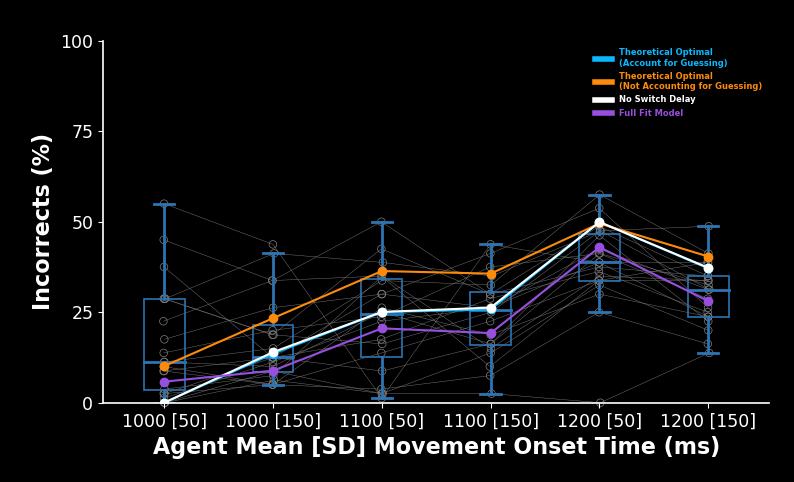

In [ ]:
metric = group.score_metrics.score_metric('incorrects')/group.exp_info.num_task_trials*100
no_switch_metric = get_no_switch_metric(model_no_switch.score_metrics.prob_incorrect, decision_type='optimal',metric_type='true') * 100
full_fit_metric = get_full_fit_metric(model_full_fit.score_metrics.prob_incorrect, decision_type='fit',metric_type='true') * 100
known_player_metric = get_known_metric(model_known_switch.score_metrics.prob_incorrect, decision_type='fit',metric_type='true') * 100
unknown_player_metric = get_unknown_metric(model_unknown_switch.score_metrics.prob_incorrect, decision_type='fit',metric_type='true') * 100
known_optimal_metric = get_known_metric(model_known_switch.score_metrics.prob_incorrect, decision_type='optimal',metric_type='true') * 100
unknown_optimal_metric = get_unknown_metric(model_unknown_switch.score_metrics.prob_incorrect, decision_type='optimal',metric_type='true') * 100
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(it.trial_block_titles))
ylocs = np.arange(0, 125, 25)

bw = 0.75
pf.multiple_models_boxplot(
    ax,
    metric,
    no_switch=no_switch_metric,
    full_fit =full_fit_metric,
    known_optimal=known_optimal_metric,
    unknown_optimal=unknown_optimal_metric,
    xlocs=xlocs,
    box_width=bw,
    colors=wheel.grey,
    remove_parentheses_from_labels=False,
)

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))
ax.set_xticks(xlocs), ax.set_yticks(ylocs)
ax.set_xticklabels(it.trial_block_titles)
ax.set_ylim(0, 100)
ax.set_xlabel(it.xlabel)
ax.set_ylabel("Incorrects (%)")
# dv.custom_legend(ax,['Theoretical Optimal of Group','Model Prediction of Group'],['Orange','Green'])

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "incorrects_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

Indecisions


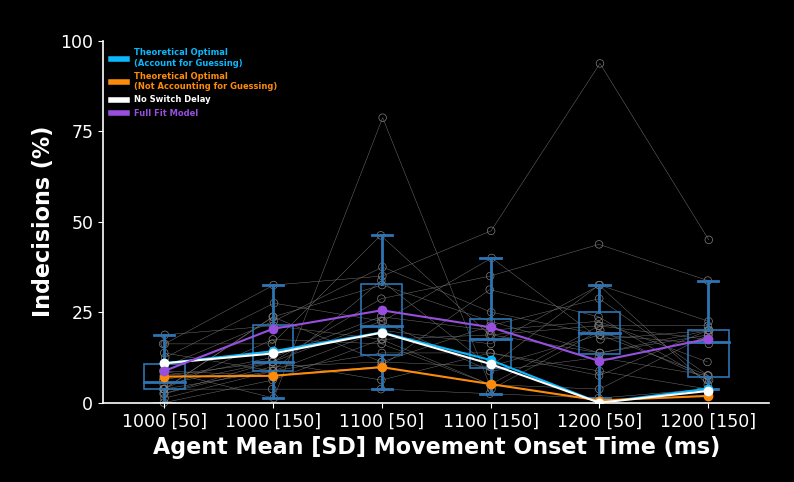

In [ ]:
metric = group.score_metrics.score_metric('indecisions')/group.exp_info.num_task_trials*100
no_switch_metric = get_no_switch_metric(model_no_switch.score_metrics.prob_indecision, decision_type='optimal',metric_type='true') * 100
full_fit_metric = get_full_fit_metric(model_full_fit.score_metrics.prob_indecision, decision_type='fit',metric_type='true') * 100
known_player_metric = get_known_metric(model_known_switch.score_metrics.prob_indecision, decision_type='fit',metric_type='true') * 100
unknown_player_metric = get_unknown_metric(model_unknown_switch.score_metrics.prob_indecision, decision_type='fit',metric_type='true') * 100
known_optimal_metric = get_known_metric(model_known_switch.score_metrics.prob_indecision, decision_type='optimal',metric_type='true') * 100
unknown_optimal_metric = get_unknown_metric(model_unknown_switch.score_metrics.prob_indecision, decision_type='optimal',metric_type='true') * 100
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(it.trial_block_titles))
ylocs = np.arange(0, 125, 25)

bw = 0.75
pf.multiple_models_boxplot(
    ax,
    metric,
    full_fit =full_fit_metric,
    no_switch=no_switch_metric,
    known_optimal=known_optimal_metric,
    unknown_optimal=unknown_optimal_metric,
    xlocs=xlocs,
    box_width=bw,
    colors=wheel.grey,
    remove_parentheses_from_labels=False,
)

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))
ax.set_xticks(xlocs), ax.set_yticks(ylocs)
ax.set_xticklabels(it.trial_block_titles)
ax.set_ylim(0, 100)
ax.set_xlabel(it.xlabel)
ax.set_ylabel("Indecisions (%)")

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "indecisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

Wins, Incorrects, Indecisions on One plot


Correct Initial Decisions


In [ ]:
try:
    metric                  = group.score_metrics.correct_decisions()
    known_player_metric     = get_known_metric(model_known_switch.score_metrics.correct_decisions, metric_type='true') * 100
    unknown_player_metric   = get_unknown_metric(model_unknown_switch.score_metrics.correct_decisions, metric_type='true') * 100
    known_optimal_metric    = get_known_metric(model_known_switch.score_metrics.correct_decisions, metric_type='true') * 100
    unknown_optimal_metric  = get_unknown_metric(model_unknown_switch.score_metrics.correct_decisions, metric_type='true') * 100
    w, h = 10, 6
    axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
    xlocs = np.linspace(0, w, num=len(it.trial_block_titles))
    ylocs = np.arange(0, 125, 25)

    bw = 0.75
    pf.multiple_models_boxplot(
        ax,
        metric,
        #known_player=known_player_metric,
        #unknown_player=unknown_player_metric,
        known_optimal=known_optimal_metric,
        unknown_optimal=unknown_optimal_metric,
        xlocs=xlocs,
        box_width=bw,
        colors=wheel.grey,
        remove_parentheses_from_labels=False,
    )

    ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))
    ax.set_xticks(xlocs), ax.set_yticks(ylocs)
    ax.set_xticklabels(it.trial_block_titles)
    ax.set_ylim(0, 100)
    ax.set_xlabel(it.xlabel)
    ax.set_ylabel("Correct Decisions (%)")
    if save:
        axmain.set_axis_off()
        plt.savefig(SAVE_PATH + "incorrects_with_optimal_model", dpi=400, transparent=True)
    axmain.set_axis_off()

    plt.show()
    
except:
    pass

Reaction and Guess Decisions


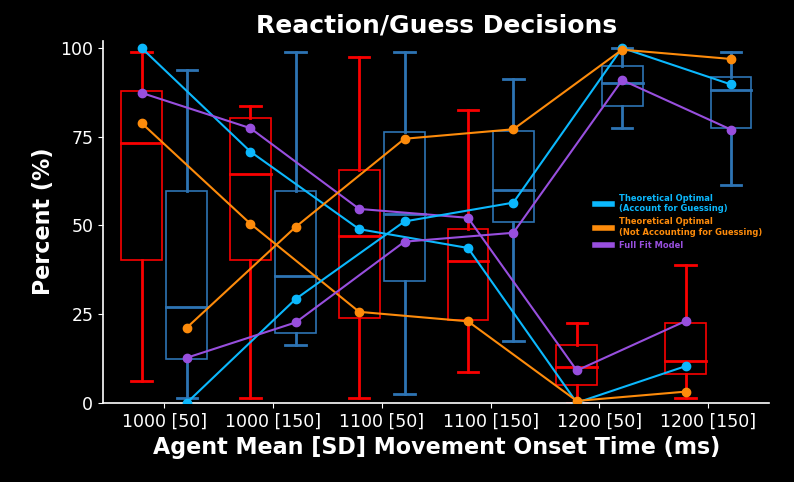

In [ ]:
unknown_player_metric1 = get_unknown_metric(model_unknown_switch.player_behavior.prob_selecting_reaction, metric_type='true',decision_type='fit') * 100
unknown_player_metric2 = get_unknown_metric(model_unknown_switch.player_behavior.prob_selecting_guess, metric_type='true',decision_type='fit') * 100
known_player_metric1 = get_unknown_metric(model_unknown_switch.player_behavior.prob_selecting_reaction, metric_type='true',decision_type='fit') * 100
known_player_metric2 = get_unknown_metric(model_unknown_switch.player_behavior.prob_selecting_guess, metric_type='true',decision_type='fit') * 100
full_fit_metric1 = get_full_fit_metric(model_full_fit.player_behavior.prob_selecting_reaction, metric_type='true',decision_type='fit',) * 100
full_fit_metric2 = get_full_fit_metric(model_full_fit.player_behavior.prob_selecting_guess, metric_type='true',decision_type='fit',) * 100

unknown_optimal_metric1 = get_unknown_metric(model_unknown_switch.player_behavior.prob_selecting_reaction,metric_type='true',decision_type='optimal') * 100
unknown_optimal_metric2 = get_unknown_metric(model_unknown_switch.player_behavior.prob_selecting_guess,metric_type='true',decision_type='optimal') * 100
known_optimal_metric1 = get_known_metric(model_known_switch.player_behavior.prob_selecting_reaction,metric_type='true',decision_type='optimal') * 100
known_optimal_metric2 = get_known_metric(model_known_switch.player_behavior.prob_selecting_guess,metric_type='true',decision_type='optimal') * 100

data_metric1 = group.react_guess_score_metrics.react_guess_decisions('react')/group.exp_info.num_task_trials*100
data_metric2 = group.react_guess_score_metrics.react_guess_decisions('guess')/group.exp_info.num_task_trials*100

# Out of x number of Reaction and Guess decisions, how many of them were indecisions
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(it.trial_block_titles))
ylocs = np.arange(0, 125, 25)


bw = 0.75
pf.multiple_models_boxplot(
    ax,
    data_metric1,
    full_fit=full_fit_metric1,
    unknown_player=None,
    known_optimal=known_optimal_metric1,
    unknown_optimal=unknown_optimal_metric1,
    xlocs=xlocs - bw / 1.8,
    box_width=bw,
    colors=wheel.seth_red,
    jitter=False,
)

pf.multiple_models_boxplot(
    ax,
    data_metric2,
    full_fit=full_fit_metric2,
    known_optimal=known_optimal_metric2,
    unknown_optimal=unknown_optimal_metric2,
    xlocs=xlocs + bw / 1.8,
    box_width=bw,
    colors=wheel.grey,
    jitter=False,
)

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xticks(xlocs), ax.set_yticks(ylocs)

ax.set_ylim(0, 102)
ax.set_xticks(xlocs)
ax.set_xticklabels(it.trial_block_titles)
ax.set_ylabel("Percent (%)")
ax.set_xlabel(it.xlabel)
ax.set_title("Reaction/Guess Decisions")
# dv.custom_legend(ax,['Reaction','guess'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "reaction_and_guess_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

Percent Indecisions That Were Reaction/guess


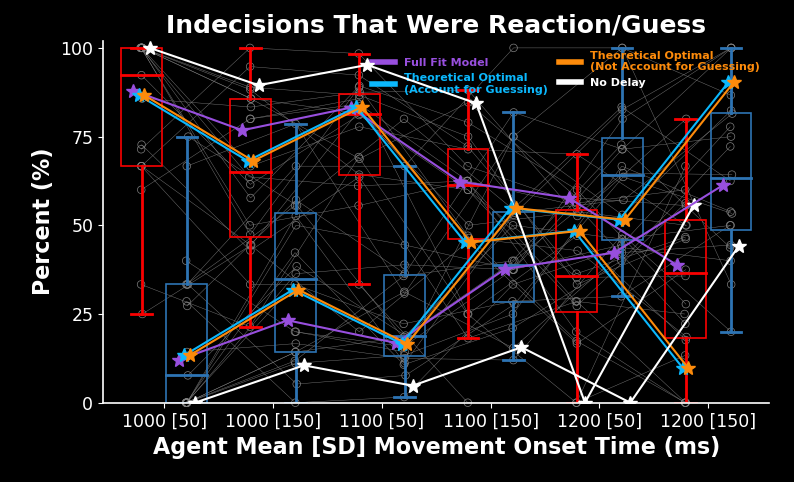

In [ ]:
# Out of x number of indecisions, how many were Reaction and Guess
data_metric1 = group.react_guess_score_metrics.score_metric_that_were_reaction_guess('indecisions','react')
data_metric2 = group.react_guess_score_metrics.score_metric_that_were_reaction_guess('indecisions','guess')

full_fit_metric1 = get_full_fit_metric(model_full_fit.score_metrics.prob_indecision_reaction, 
                                       model_full_fit.score_metrics.prob_indecision,
                                       decision_type='fit',metric_type='true',) *100
full_fit_metric2 = get_full_fit_metric(model_full_fit.score_metrics.prob_indecision_guess, 
                                        model_full_fit.score_metrics.prob_indecision,
                                       decision_type='fit',metric_type='true',)*100
no_switch_metric1 = get_no_switch_metric(model_no_switch.score_metrics.prob_indecision_reaction,
                                         model_no_switch.score_metrics.prob_indecision,
                                         decision_type='optimal',metric_type='true')*100
no_switch_metric2 = get_no_switch_metric(model_no_switch.score_metrics.prob_indecision_guess,
                                         model_no_switch.score_metrics.prob_indecision,
                                         decision_type='optimal',metric_type='true')*100


unknown_optimal_metric1 = get_unknown_metric(model_unknown_switch.score_metrics.prob_indecision_reaction,
                                        model_unknown_switch.score_metrics.prob_indecision,
                                        decision_type='optimal', metric_type='true')*100
unknown_optimal_metric2 = get_unknown_metric(model_unknown_switch.score_metrics.prob_indecision_guess,
                                        model_unknown_switch.score_metrics.prob_indecision,
                                        decision_type='optimal', metric_type='true')*100
known_optimal_metric1 = get_unknown_metric(model_unknown_switch.score_metrics.prob_indecision_reaction,
                                        model_unknown_switch.score_metrics.prob_indecision,
                                        decision_type='optimal', metric_type='true')*100
known_optimal_metric2 = get_unknown_metric(model_unknown_switch.score_metrics.prob_indecision_guess,
                                        model_unknown_switch.score_metrics.prob_indecision,
                                        decision_type='optimal', metric_type='true')*100

# Out of x number of Reaction and Guess decisions, how many of them were indecisions
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(it.trial_block_titles))
ylocs = np.arange(0, 125, 25)
bw = 0.75

pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric1,
    model_data=[full_fit_metric1, known_optimal_metric1, unknown_optimal_metric1, no_switch_metric1],
    labels=['Full Fit Model', 'Theoretical Optimal\n(Account for Guessing)', 'Theoretical Optimal\n(Not Account for Guessing)', 'No Delay'],
    show_boxplot=True,
    xlocs=xlocs - bw/1.8,
    ylocs=ylocs,
    box_width=0.75,
    colors=wheel.seth_red,
    line_colors = [wheel.purple, wheel.rak_blue, wheel.rak_orange,wheel.white],
    linestyles=None,
    xticklabels=it.trial_block_titles,    
    xlabel= it.xlabel, 
    ylabel = "Percent (%)",
    title='Indecisions That Were Reaction/Guess',    
    legend_fontsize = 8
    )
pf.multiple_models_boxplot_v2(
    ax=ax,
    data=data_metric2,
    model_data=[full_fit_metric2, known_optimal_metric2, unknown_optimal_metric2, no_switch_metric2],
    labels=['Full Fit Model', 'Theoretical Optimal\n(Account for Guessing)', 'Theoretical Optimal\n(Not Account for Guessing)', 'No Delay'],
    show_boxplot=True,
    xlocs=xlocs + bw/1.8,
    ylocs=ylocs,
    box_width=0.75,
    colors=wheel.grey,
    line_colors = [wheel.purple, wheel.rak_blue, wheel.rak_orange,wheel.white],
    linestyles=None,
    xticklabels=it.trial_block_titles,    
    xlabel= it.xlabel, 
    ylabel = "Percent (%)",
    title='Indecisions That Were Reaction/Guess',    
    legend_fontsize = 8
    )

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xticks(xlocs), ax.set_yticks(ylocs)

ax.set_ylim(0, 102)
ax.set_xticks(xlocs)
ax.set_xticklabels(it.trial_block_titles)
ax.set_ylabel("Percent (%)")
ax.set_xlabel(it.xlabel)
ax.set_title("Indecisions That Were Reaction/Guess")
# dv.custom_legend(ax,['Reaction','guess'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "reaction_and_guess_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

Reaction and Guess Leave Times


In [ ]:
no_switch_metric2

array([0.000140292, 10.525237950, 4.792180675, 15.631498696, 0.000000000,
       44.298136405])

c:\Users\Seth Sullivan\anaconda3\envs\aim1\lib\site-packages\numpy\lib\nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


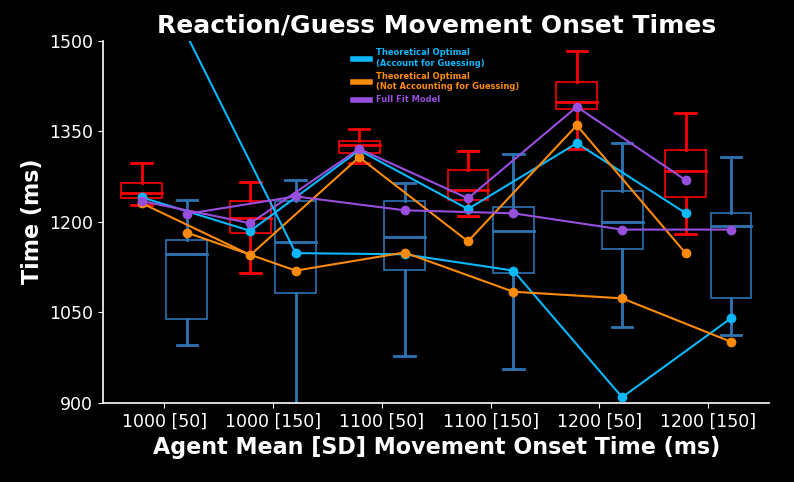

In [ ]:
data_metric1 = np.nanmedian(group.react_guess_movement_metrics.movement_onset_times('react'), axis=2)
data_metric2 = np.nanmedian(group.react_guess_movement_metrics.movement_onset_times('guess'), axis=2)
# unknown_player_metric1 = get_unknown_metric(model_unknown_switch.player_behavior.reaction_leave_time, metric_type='true',decision_type='fit')
# unknown_player_metric2 = get_unknown_metric(model_unknown_switch.player_behavior.guess_leave_time, metric_type='true',decision_type='fit')
# known_player_metric1 = get_known_metric(model_known_switch.player_behavior.reaction_leave_time, metric_type='true',decision_type='fit')
# known_player_metric2 = get_known_metric(model_known_switch.player_behavior.guess_leave_time, metric_type='true',decision_type='fit')

full_fit_metric1 = get_full_fit_metric(model_full_fit.player_behavior.reaction_leave_time, metric_type='true',decision_type='fit',) 
full_fit_metric2 = get_full_fit_metric(model_full_fit.player_behavior.guess_leave_time, metric_type='true',decision_type='fit',)

no_switch_metric1 = get_no_switch_metric(model_no_switch.player_behavior.reaction_leave_time,metric_type='true',decision_type='optimal')
no_switch_metric2 = get_no_switch_metric(model_no_switch.player_behavior.guess_leave_time,metric_type='true',decision_type='optimal')

unknown_optimal_metric1 = get_unknown_metric(model_unknown_switch.player_behavior.reaction_leave_time,metric_type='true',decision_type='optimal')
unknown_optimal_metric2 = get_unknown_metric(model_unknown_switch.player_behavior.guess_leave_time,metric_type='true',decision_type='optimal')
known_optimal_metric1 = get_known_metric(model_known_switch.player_behavior.reaction_leave_time,metric_type='true',decision_type='optimal')
known_optimal_metric2 = get_known_metric(model_known_switch.player_behavior.guess_leave_time,metric_type='true',decision_type='optimal')

# Out of x number of Reaction and Guess decisions, how many of them were indecisions
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(it.trial_block_titles))
ylocs = np.arange(900, 1650, 150)


bw = 0.75
pf.multiple_models_boxplot(
    ax,
    data_metric1,
    full_fit=full_fit_metric1,
    unknown_player=None,
    known_optimal=known_optimal_metric1,
    unknown_optimal=unknown_optimal_metric1,
    xlocs=xlocs - bw / 1.8,
    box_width=bw,
    colors=wheel.seth_red,
    jitter=False,
)

pf.multiple_models_boxplot(
    ax,
    data_metric2,
    full_fit=full_fit_metric2,
    known_optimal=known_optimal_metric2,
    unknown_optimal=unknown_optimal_metric2,
    xlocs=xlocs + bw / 1.8,
    box_width=bw,
    colors=wheel.grey,
    jitter=False,
)

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xticks(xlocs), ax.set_yticks(ylocs)

ax.set_xticks(xlocs)
ax.set_xticklabels(it.trial_block_titles)
ax.set_ylabel("Time (ms)")
ax.set_xlabel(it.xlabel)
ax.set_title("Reaction/Guess Movement Onset Times")
# dv.custom_legend(ax,['Reaction','guess'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "reaction_and_guess_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

Agent Reaction and Guess Decision Times


c:\Users\Seth Sullivan\anaconda3\envs\aim1\lib\site-packages\numpy\lib\nanfunctions.py:1218: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


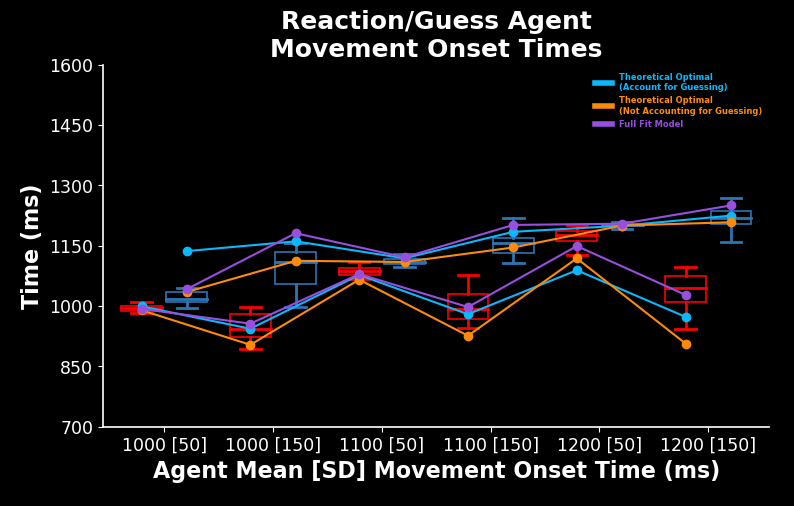

In [ ]:
data_metric1 = np.nanmedian(group.react_guess_movement_metrics.agent_movement_onset_times('react'), axis=2)
data_metric2 = np.nanmedian(group.react_guess_movement_metrics.agent_movement_onset_times('guess'), axis=2)

# unknown_player_metric1 = get_unknown_metric(model_unknown_switch.agent_behavior.reaction_leave_time, metric_type='true',decision_type='optimal')
# unknown_player_metric2 = get_unknown_metric(model_unknown_switch.agent_behavior.guess_leave_time, metric_type='true',decision_type='optimal')
# known_player_metric1 = get_known_metric(model_known_switch.agent_behavior.reaction_leave_time, metric_type='true',decision_type='optimal')
# known_player_metric2 = get_known_metric(model_known_switch.agent_behavior.guess_leave_time, metric_type='true',decision_type='optimal')
full_fit_metric1 = get_full_fit_metric(model_full_fit.agent_behavior.reaction_leave_time , metric_type='true',decision_type='fit',) 
full_fit_metric2 = get_full_fit_metric(model_full_fit.agent_behavior.guess_leave_time , metric_type='true',decision_type='fit',)
unknown_optimal_metric1 = get_unknown_metric(model_unknown_switch.agent_behavior.reaction_leave_time,metric_type='true',decision_type='optimal')
unknown_optimal_metric2 = get_unknown_metric(model_unknown_switch.agent_behavior.guess_leave_time,metric_type='true',decision_type='optimal')
known_optimal_metric1 = get_known_metric(model_known_switch.agent_behavior.reaction_leave_time,metric_type='true',decision_type='optimal')
known_optimal_metric2 = get_known_metric(model_known_switch.agent_behavior.guess_leave_time,metric_type='true',decision_type='optimal')

# Out of x number of Reaction and Guess decisions, how many of them were indecisions
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(it.trial_block_titles))
ylocs = np.arange(700, 1750, 150)


bw = 0.75
pf.multiple_models_boxplot(
    ax,
    data_metric1,
    full_fit=full_fit_metric1,
    unknown_player=None,
    known_optimal=known_optimal_metric1,
    unknown_optimal=unknown_optimal_metric1,
    xlocs=xlocs - bw / 1.8,
    box_width=bw,
    colors=wheel.seth_red,
    jitter=False,
)

pf.multiple_models_boxplot(
    ax,
    data_metric2,
    full_fit=full_fit_metric2,
    known_optimal=known_optimal_metric2,
    unknown_optimal=unknown_optimal_metric2,
    xlocs=xlocs + bw / 1.8,
    box_width=bw,
    colors=wheel.grey,
    jitter=False,
)

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xticks(xlocs), ax.set_yticks(ylocs)

ax.set_xticks(xlocs)
ax.set_xticklabels(it.trial_block_titles)
ax.set_ylabel("Time (ms)")
ax.set_xlabel(it.xlabel)
ax.set_title("Reaction/Guess Agent\nMovement Onset Times")
# dv.custom_legend(ax,['Reaction','guess'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "reaction_and_guess_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

Indecisions That Were guess


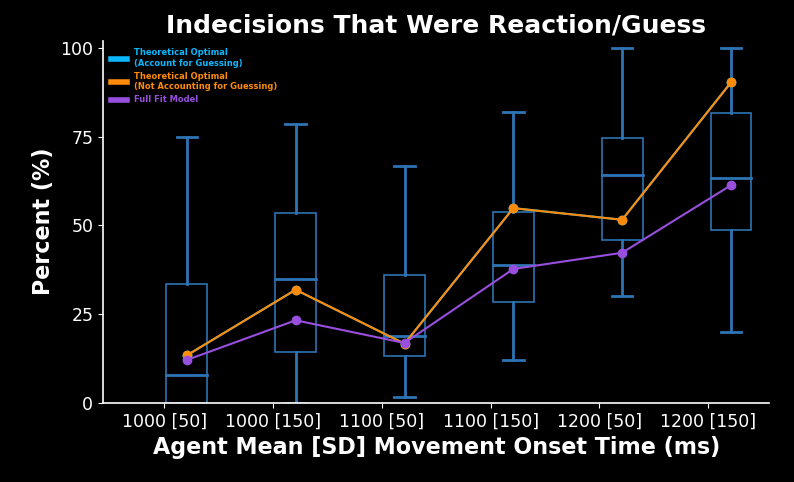

In [ ]:
# Out of x number of indecisions, how many were Reaction and Guess
data_metric1 = group.react_guess_score_metrics.score_metric_that_were_reaction_guess('indecisions','react')
data_metric2 = group.react_guess_score_metrics.score_metric_that_were_reaction_guess('indecisions','guess')

full_fit_metric1 = get_full_fit_metric(model_full_fit.score_metrics.prob_indecision_reaction, 
                                       model_full_fit.score_metrics.prob_indecision,
                                       metric_type='true',decision_type='fit',) *100
full_fit_metric2 = get_full_fit_metric(model_full_fit.score_metrics.prob_indecision_guess, 
                                        model_full_fit.score_metrics.prob_indecision,
                                       metric_type='true',decision_type='fit',)*100

unknown_optimal_metric1 = get_unknown_metric(model_unknown_switch.score_metrics.prob_indecision_reaction,
                                        model_unknown_switch.score_metrics.prob_indecision,
                                        decision_type='optimal', metric_type='true')*100
unknown_optimal_metric2 = get_unknown_metric(model_unknown_switch.score_metrics.prob_indecision_guess,
                                        model_unknown_switch.score_metrics.prob_indecision,
                                        decision_type='optimal', metric_type='true')*100
known_optimal_metric1 = get_unknown_metric(model_unknown_switch.score_metrics.prob_indecision_reaction,
                                        model_unknown_switch.score_metrics.prob_indecision,
                                        decision_type='optimal', metric_type='true')*100
known_optimal_metric2 = get_unknown_metric(model_unknown_switch.score_metrics.prob_indecision_guess,
                                        model_unknown_switch.score_metrics.prob_indecision,
                                        decision_type='optimal', metric_type='true')*100

# Out of x number of Reaction and Guess decisions, how many of them were indecisions
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(it.trial_block_titles))
ylocs = np.arange(0, 125, 25)


bw = 0.75
# 


pf.multiple_models_boxplot(
    ax,
    data_metric2,
    full_fit=full_fit_metric2,
    known_optimal=known_optimal_metric2,
    unknown_optimal=unknown_optimal_metric2,
    xlocs=xlocs + bw / 1.8,
    box_width=bw,
    colors=wheel.grey,
    jitter=False,
)

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xticks(xlocs), ax.set_yticks(ylocs)

ax.set_ylim(0, 102)
ax.set_xticks(xlocs)
ax.set_xticklabels(it.trial_block_titles)
ax.set_ylabel("Percent (%)")
ax.set_xlabel(it.xlabel)
ax.set_title("Indecisions That Were Reaction/Guess")
# dv.custom_legend(ax,['Reaction','guess'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "reaction_and_guess_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

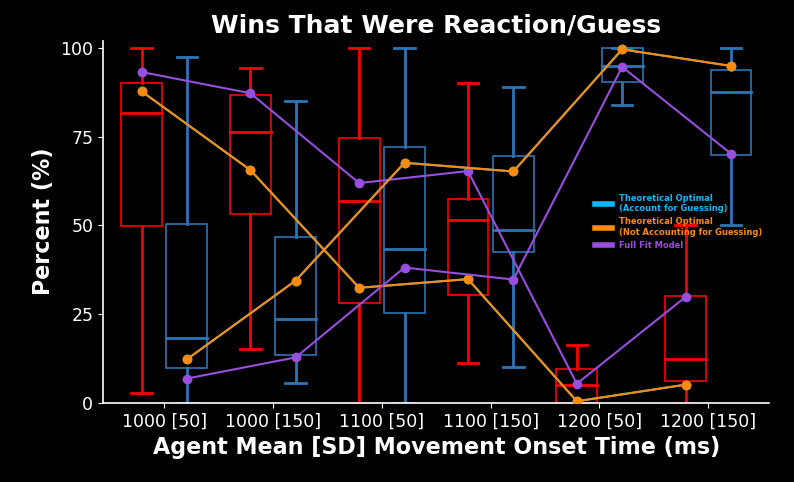

In [ ]:
# Out of x number of wins, how many were Reaction and Guess
data_metric1 = group.react_guess_score_metrics.score_metric_that_were_reaction_guess('wins','react')
data_metric2 = group.react_guess_score_metrics.score_metric_that_were_reaction_guess('wins','guess')

full_fit_metric1 = get_full_fit_metric(model_full_fit.score_metrics.prob_win_reaction, 
                                       model_full_fit.score_metrics.prob_win,
                                       metric_type='true',decision_type='fit',) *100
full_fit_metric2 = get_full_fit_metric(model_full_fit.score_metrics.prob_win_guess, 
                                        model_full_fit.score_metrics.prob_win,
                                       metric_type='true',decision_type='fit',)*100

unknown_optimal_metric1 = get_unknown_metric(model_unknown_switch.score_metrics.prob_win_reaction,
                                        model_unknown_switch.score_metrics.prob_win,
                                        decision_type='optimal', metric_type='true')*100
unknown_optimal_metric2 = get_unknown_metric(model_unknown_switch.score_metrics.prob_win_guess,
                                        model_unknown_switch.score_metrics.prob_win,
                                        decision_type='optimal', metric_type='true')*100
known_optimal_metric1 = get_unknown_metric(model_unknown_switch.score_metrics.prob_win_reaction,
                                        model_unknown_switch.score_metrics.prob_win,
                                        decision_type='optimal', metric_type='true')*100
known_optimal_metric2 = get_unknown_metric(model_unknown_switch.score_metrics.prob_win_guess,
                                        model_unknown_switch.score_metrics.prob_win,
                                        decision_type='optimal', metric_type='true')*100

# Out of x number of Reaction and Guess decisions, how many of them were wins
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(it.trial_block_titles))
ylocs = np.arange(0, 125, 25)


bw = 0.75
pf.multiple_models_boxplot(
    ax,
    data_metric1,
    full_fit=full_fit_metric1,
    unknown_player=None,
    known_optimal=known_optimal_metric1,
    unknown_optimal=unknown_optimal_metric1,
    xlocs=xlocs - bw / 1.8,
    box_width=bw,
    colors=wheel.seth_red,
    jitter=False,
)

pf.multiple_models_boxplot(
    ax,
    data_metric2,
    full_fit=full_fit_metric2,
    known_optimal=known_optimal_metric2,
    unknown_optimal=unknown_optimal_metric2,
    xlocs=xlocs + bw / 1.8,
    box_width=bw,
    colors=wheel.grey,
    jitter=False,
)

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xticks(xlocs), ax.set_yticks(ylocs)

ax.set_ylim(0, 102)
ax.set_xticks(xlocs)
ax.set_xticklabels(it.trial_block_titles)
ax.set_ylabel("Percent (%)")
ax.set_xlabel(it.xlabel)
ax.set_title("Wins That Were Reaction/Guess")
# dv.custom_legend(ax,['Reaction','guess'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "reaction_and_guess_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

Incorrects that were Reaction and Guess


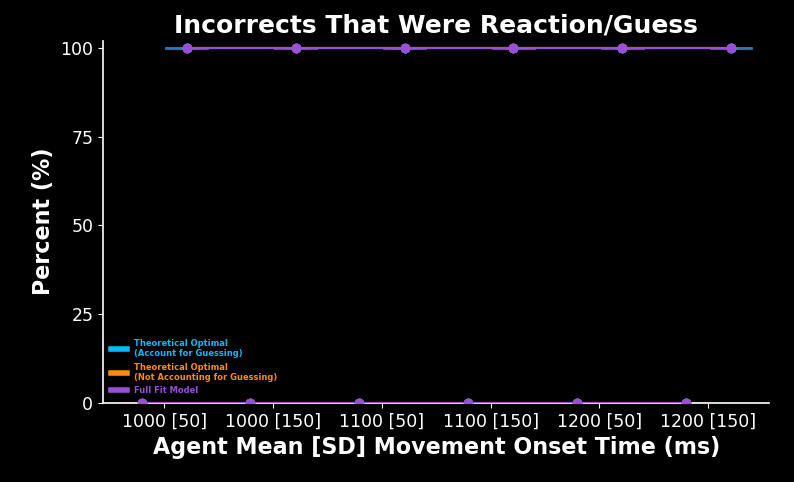

In [ ]:
# Out of x number of incorrects, how many were Reaction and Guess
data_metric1 = group.react_guess_score_metrics.score_metric_that_were_reaction_guess('incorrects','react')
data_metric2 = group.react_guess_score_metrics.score_metric_that_were_reaction_guess('incorrects','guess')

full_fit_metric1 = get_full_fit_metric(model_full_fit.score_metrics.prob_incorrect_reaction, 
                                       model_full_fit.score_metrics.prob_incorrect,
                                       metric_type='true',decision_type='fit',) *100
full_fit_metric2 = get_full_fit_metric(model_full_fit.score_metrics.prob_incorrect_guess, 
                                        model_full_fit.score_metrics.prob_incorrect,
                                       metric_type='true',decision_type='fit',)*100

unknown_optimal_metric1 = get_unknown_metric(model_unknown_switch.score_metrics.prob_incorrect_reaction,
                                        model_unknown_switch.score_metrics.prob_incorrect,
                                        decision_type='optimal', metric_type='true')*100
unknown_optimal_metric2 = get_unknown_metric(model_unknown_switch.score_metrics.prob_incorrect_guess,
                                        model_unknown_switch.score_metrics.prob_incorrect,
                                        decision_type='optimal', metric_type='true')*100
known_optimal_metric1 = get_unknown_metric(model_unknown_switch.score_metrics.prob_incorrect_reaction,
                                        model_unknown_switch.score_metrics.prob_incorrect,
                                        decision_type='optimal', metric_type='true')*100
known_optimal_metric2 = get_unknown_metric(model_unknown_switch.score_metrics.prob_incorrect_guess,
                                        model_unknown_switch.score_metrics.prob_incorrect,
                                        decision_type='optimal', metric_type='true')*100

# Out of x number of Reaction and Guess decisions, how many of them were incorrects
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(it.trial_block_titles))
ylocs = np.arange(0, 125, 25)


bw = 0.75
pf.multiple_models_boxplot(
    ax,
    data_metric1,
    full_fit=full_fit_metric1,
    unknown_player=None,
    known_optimal=known_optimal_metric1,
    unknown_optimal=unknown_optimal_metric1,
    xlocs=xlocs - bw / 1.8,
    box_width=bw,
    colors=wheel.seth_red,
    jitter=False,
)

pf.multiple_models_boxplot(
    ax,
    data_metric2,
    full_fit=full_fit_metric2,
    known_optimal=known_optimal_metric2,
    unknown_optimal=unknown_optimal_metric2,
    xlocs=xlocs + bw / 1.8,
    box_width=bw,
    colors=wheel.grey,
    jitter=False,
)

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xticks(xlocs), ax.set_yticks(ylocs)

ax.set_ylim(0, 102)
ax.set_xticks(xlocs)
ax.set_xticklabels(it.trial_block_titles)
ax.set_ylabel("Percent (%)")
ax.set_xlabel(it.xlabel)
ax.set_title("Incorrects That Were Reaction/Guess")
# dv.custom_legend(ax,['Reaction','guess'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "reaction_and_guess_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

OUt of the Reaction/guess How many times did they win


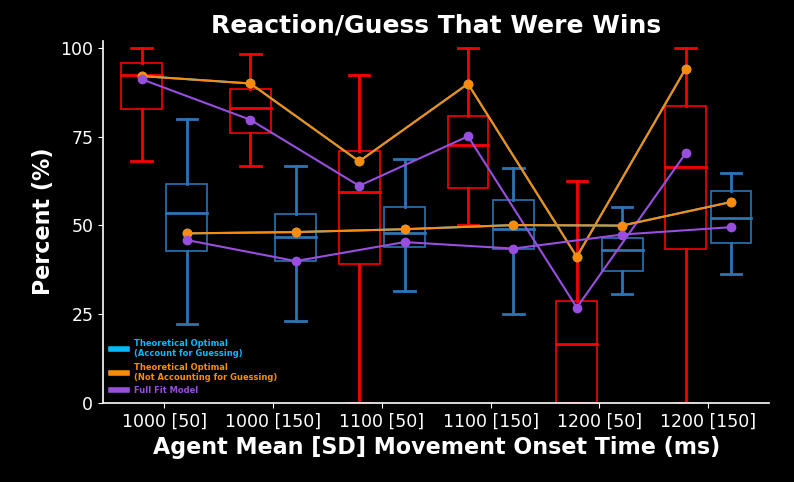

In [ ]:
# Out of x number of wins, how many were Reaction and Guess
data_metric1 = group.react_guess_score_metrics.react_guess_that_were_score_metric('wins','react')
data_metric2 = group.react_guess_score_metrics.react_guess_that_were_score_metric('wins','guess')

full_fit_metric1 = get_full_fit_metric(model_full_fit.score_metrics.prob_win_reaction, 
                                       model_full_fit.player_behavior.prob_selecting_reaction,
                                       metric_type='true',decision_type='fit',) *100
full_fit_metric2 = get_full_fit_metric(model_full_fit.score_metrics.prob_win_guess, 
                                        model_full_fit.player_behavior.prob_selecting_guess,
                                       metric_type='true',decision_type='fit',)*100

unknown_optimal_metric1 = get_unknown_metric(model_unknown_switch.score_metrics.prob_win_reaction,
                                        model_unknown_switch.player_behavior.prob_selecting_reaction,
                                        decision_type='optimal', metric_type='true')*100
unknown_optimal_metric2 = get_unknown_metric(model_unknown_switch.score_metrics.prob_win_guess,
                                        model_unknown_switch.player_behavior.prob_selecting_guess,
                                        decision_type='optimal', metric_type='true')*100
known_optimal_metric1 = get_unknown_metric(model_unknown_switch.score_metrics.prob_win_reaction,
                                        model_unknown_switch.player_behavior.prob_selecting_reaction,
                                        decision_type='optimal', metric_type='true')*100
known_optimal_metric2 = get_unknown_metric(model_unknown_switch.score_metrics.prob_win_guess,
                                        model_unknown_switch.player_behavior.prob_selecting_guess,
                                        decision_type='optimal', metric_type='true')*100

# Out of x number of Reaction and Guess decisions, how many of them were wins
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(it.trial_block_titles))
ylocs = np.arange(0, 125, 25)


bw = 0.75
pf.multiple_models_boxplot(
    ax,
    data_metric1,
    full_fit=full_fit_metric1,
    unknown_player=None,
    known_optimal=known_optimal_metric1,
    unknown_optimal=unknown_optimal_metric1,
    xlocs=xlocs - bw / 1.8,
    box_width=bw,
    colors=wheel.seth_red,
    jitter=False,
)

pf.multiple_models_boxplot(
    ax,
    data_metric2,
    full_fit=full_fit_metric2,
    known_optimal=known_optimal_metric2,
    unknown_optimal=unknown_optimal_metric2,
    xlocs=xlocs + bw / 1.8,
    box_width=bw,
    colors=wheel.grey,
    jitter=False,
)

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xticks(xlocs), ax.set_yticks(ylocs)

ax.set_ylim(0, 102)
ax.set_xticks(xlocs)
ax.set_xticklabels(it.trial_block_titles)
ax.set_ylabel("Percent (%)")
ax.set_xlabel(it.xlabel)
ax.set_title("Reaction/Guess That Were Wins")
# dv.custom_legend(ax,['Reaction','guess'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "reaction_and_guess_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

Percent Reaction and Guess That Were Indecisions


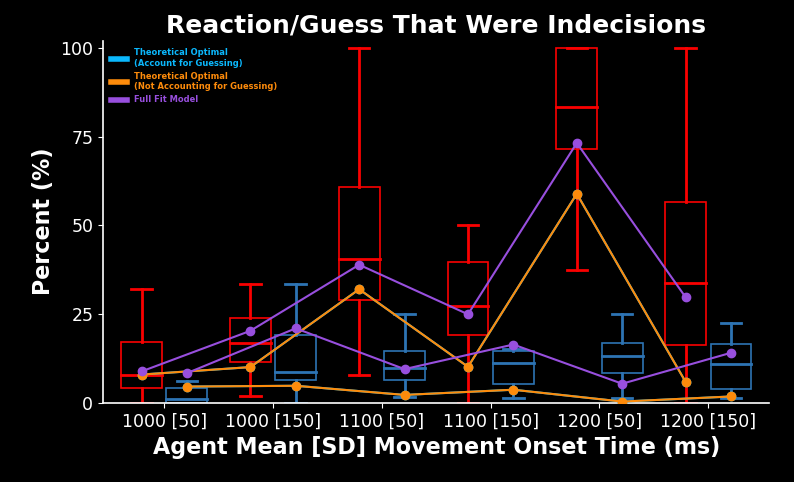

In [ ]:
# Out of x number of indecisions, how many were Reaction and Guess
data_metric1 = group.react_guess_score_metrics.react_guess_that_were_score_metric('indecisions','react')
data_metric2 = group.react_guess_score_metrics.react_guess_that_were_score_metric('indecisions','guess')

full_fit_metric1 = get_full_fit_metric(model_full_fit.score_metrics.prob_indecision_reaction, 
                                       model_full_fit.player_behavior.prob_selecting_reaction,
                                       metric_type='true',decision_type='fit',) *100
full_fit_metric2 = get_full_fit_metric(model_full_fit.score_metrics.prob_indecision_guess, 
                                        model_full_fit.player_behavior.prob_selecting_guess,
                                       metric_type='true',decision_type='fit',)*100

unknown_optimal_metric1 = get_unknown_metric(model_unknown_switch.score_metrics.prob_indecision_reaction,
                                        model_unknown_switch.player_behavior.prob_selecting_reaction,
                                        decision_type='optimal', metric_type='true')*100
unknown_optimal_metric2 = get_unknown_metric(model_unknown_switch.score_metrics.prob_indecision_guess,
                                        model_unknown_switch.player_behavior.prob_selecting_guess,
                                        decision_type='optimal', metric_type='true')*100
known_optimal_metric1 = get_unknown_metric(model_unknown_switch.score_metrics.prob_indecision_reaction,
                                        model_unknown_switch.player_behavior.prob_selecting_reaction,
                                        decision_type='optimal', metric_type='true')*100
known_optimal_metric2 = get_unknown_metric(model_unknown_switch.score_metrics.prob_indecision_guess,
                                        model_unknown_switch.player_behavior.prob_selecting_guess,
                                        decision_type='optimal', metric_type='true')*100

# Out of x number of Reaction and Guess decisions, how many of them were indecisions
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(it.trial_block_titles))
ylocs = np.arange(0, 125, 25)


bw = 0.75
pf.multiple_models_boxplot(
    ax,
    data_metric1,
    full_fit=full_fit_metric1,
    unknown_player=None,
    known_optimal=known_optimal_metric1,
    unknown_optimal=unknown_optimal_metric1,
    xlocs=xlocs - bw / 1.8,
    box_width=bw,
    colors=wheel.seth_red,
    jitter=False,
)

pf.multiple_models_boxplot(
    ax,
    data_metric2,
    full_fit=full_fit_metric2,
    known_optimal=known_optimal_metric2,
    unknown_optimal=unknown_optimal_metric2,
    xlocs=xlocs + bw / 1.8,
    box_width=bw,
    colors=wheel.grey,
    jitter=False,
)

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xticks(xlocs), ax.set_yticks(ylocs)

ax.set_ylim(0, 102)
ax.set_xticks(xlocs)
ax.set_xticklabels(it.trial_block_titles)
ax.set_ylabel("Percent (%)")
ax.set_xlabel(it.xlabel)
ax.set_title("Reaction/Guess That Were Indecisions")
# dv.custom_legend(ax,['Reaction','guess'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "reaction_and_guess_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()

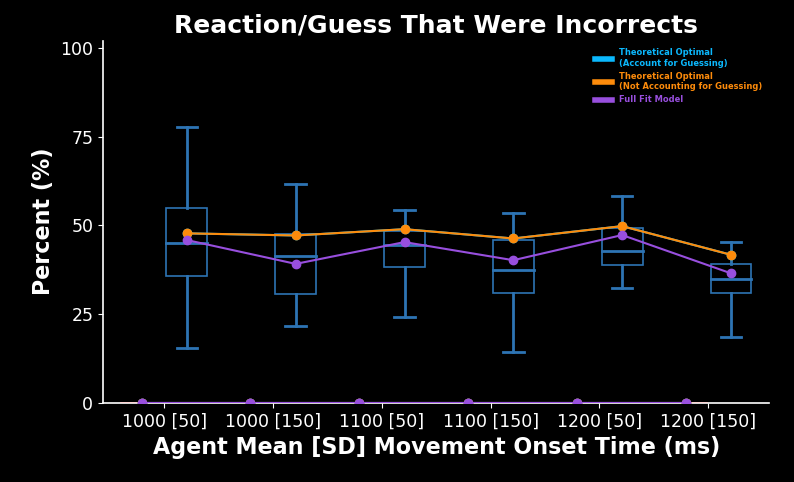

In [ ]:
# Out of x number of incorrects, how many were Reaction and Guess
data_metric1 = group.react_guess_score_metrics.react_guess_that_were_score_metric('incorrects','react')
data_metric2 = group.react_guess_score_metrics.react_guess_that_were_score_metric('incorrects','guess')

full_fit_metric1 = get_full_fit_metric(model_full_fit.score_metrics.prob_incorrect_reaction, 
                                       model_full_fit.player_behavior.prob_selecting_reaction,
                                       metric_type='true',decision_type='fit',) *100
full_fit_metric2 = get_full_fit_metric(model_full_fit.score_metrics.prob_incorrect_guess, 
                                        model_full_fit.player_behavior.prob_selecting_guess,
                                       metric_type='true',decision_type='fit',)*100

unknown_optimal_metric1 = get_unknown_metric(model_unknown_switch.score_metrics.prob_incorrect_reaction,
                                        model_unknown_switch.player_behavior.prob_selecting_reaction,
                                        decision_type='optimal', metric_type='true')*100
unknown_optimal_metric2 = get_unknown_metric(model_unknown_switch.score_metrics.prob_incorrect_guess,
                                        model_unknown_switch.player_behavior.prob_selecting_guess,
                                        decision_type='optimal', metric_type='true')*100
known_optimal_metric1 = get_unknown_metric(model_unknown_switch.score_metrics.prob_incorrect_reaction,
                                        model_unknown_switch.player_behavior.prob_selecting_reaction,
                                        decision_type='optimal', metric_type='true')*100
known_optimal_metric2 = get_unknown_metric(model_unknown_switch.score_metrics.prob_incorrect_guess,
                                        model_unknown_switch.player_behavior.prob_selecting_guess,
                                        decision_type='optimal', metric_type='true')*100

# Out of x number of Reaction and Guess decisions, how many of them were incorrects
w, h = 10, 6
axmain, ax = pf.make_figure_panel(figsize=(w, h), inset_size=(1.2, 0.9, w - 1.4, h - 1.3))
xlocs = np.linspace(0, w, num=len(it.trial_block_titles))
ylocs = np.arange(0, 125, 25)


bw = 0.75
pf.multiple_models_boxplot(
    ax,
    data_metric1,
    full_fit=full_fit_metric1,
    unknown_player=None,
    known_optimal=known_optimal_metric1,
    unknown_optimal=unknown_optimal_metric1,
    xlocs=xlocs - bw / 1.8,
    box_width=bw,
    colors=wheel.seth_red,
    jitter=False,
)

pf.multiple_models_boxplot(
    ax,
    data_metric2,
    full_fit=full_fit_metric2,
    known_optimal=known_optimal_metric2,
    unknown_optimal=unknown_optimal_metric2,
    xlocs=xlocs + bw / 1.8,
    box_width=bw,
    colors=wheel.grey,
    jitter=False,
)

ax.set_xlim(min(xlocs) - 1.5 * bw, max(xlocs) + 1.5 * bw), ax.set_ylim(min(ylocs), max(ylocs))

ax.set_xticks(xlocs), ax.set_yticks(ylocs)

ax.set_ylim(0, 102)
ax.set_xticks(xlocs)
ax.set_xticklabels(it.trial_block_titles)
ax.set_ylabel("Percent (%)")
ax.set_xlabel(it.xlabel)
ax.set_title("Reaction/Guess That Were Incorrects")
# dv.custom_legend(ax,['Reaction','guess'],[wheel.seth_red,wheel.seth_blue],fontsize=10,loc =  (0.9,1))

if save:
    axmain.set_axis_off()
    plt.savefig(SAVE_PATH + "reaction_and_guess_decisions_with_optimal_model", dpi=400, transparent=True)
axmain.set_axis_off()

plt.show()